# 1. Business Problem Statement

The Kaggle dataset represents a **general e-commerce retail model**, where churn means customers became inactive.  
In retail e-commerce, annual churn rates of **60–80%** are common ([Ecommerce Fastlane](https://ecommercefastlane.com/ecommerce-churn-rates-measure-and-reduce-lost-customers-and-revenue/?utm_source=chatgpt.com); [Sobot.io](https://www.sobot.io/article/average-churn-rate-for-ecommerce-stores-trends-2024-2025/?utm_source=chatgpt.com)).  

For this project, we **assume the dataset reflects one month of customer activity**. Under this assumption, the ~16% churn rate is far above healthy monthly benchmarks of **5–10%** seen in subscription-style e-commerce ([ScaleMath](https://scalemath.com/blog/what-is-a-good-monthly-churn-rate/?utm_source=chatgpt.com); [Opensend](https://www.opensend.com/post/churn-rate-ecommerce?utm_source=chatgpt.com)).  
This makes churn reduction a **serious business problem** and a strong candidate for predictive modeling and retention strategies.

## 1.1. Evaluation Metrics

For this churn dataset, the following evaluation setup will be used:

1. **Main Metric → F2-Score**  
   - Prioritizes Recall 4× more than Precision, reflecting the fact that **acquiring a new customer is 5–25× more expensive than retaining an existing one** ([Harvard Business Review, 2014](https://hbr.org/2014/10/the-value-of-keeping-the-right-customers?utm_source=chatgpt.com)).  
   - This makes missing churners (false negatives) far more costly than mistakenly targeting loyal customers (false positives).  
   - Supported by churn prediction literature, where Recall-oriented metrics (e.g., F2) are recommended for imbalanced datasets ([Verbeke et al., 2012](https://doi.org/10.1016/j.dss.2012.05.005)).  

2. **Supporting Metric → ROC-AUC**  
   - Evaluates model discriminative power independent of thresholds.  
   - Widely used in churn research as a benchmark for classification quality.  

3. **Supporting Tool → Precision & Recall**  
   - Reports Precision and Recall for each class.  
   - Provides transparency into trade-offs, allowing business stakeholders to see exactly how many churners are caught versus how many loyal customers are misclassified.  

**Summary:**  
- **F2-Score** will be the headline evaluation metric.  
- **ROC-AUC** provides a threshold-independent comparison across models.  
- **Precision & Recall** ensures interpretability and business clarity.

# 2. Data Understanding

In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Load the datasets
file_path = 'E Commerce Dataset.xlsx'
df_ecommerce = pd.read_excel(file_path, sheet_name='E Comm')
df_dict = pd.read_excel(file_path, sheet_name='Data Dict')

print("Feature Descriptions:")
display(df_dict)

print("\nE-commerce Data Head:")
display(df_ecommerce.head())

Feature Descriptions:


Unnamed: 0 Unnamed: 1                   Unnamed: 2  \
0          NaN       Data                     Variable   
1          NaN     E Comm                   CustomerID   
2          NaN     E Comm                        Churn   
3          NaN     E Comm                       Tenure   
4          NaN     E Comm         PreferredLoginDevice   
5          NaN     E Comm                     CityTier   
6          NaN     E Comm              WarehouseToHome   
7          NaN     E Comm         PreferredPaymentMode   
8          NaN     E Comm                       Gender   
9          NaN     E Comm               HourSpendOnApp   
10         NaN     E Comm     NumberOfDeviceRegistered   
11         NaN     E Comm             PreferedOrderCat   
12         NaN     E Comm            SatisfactionScore   
13         NaN     E Comm                MaritalStatus   
14         NaN     E Comm              NumberOfAddress   
15         NaN     E Comm                     Complain   
16         NaN     E Comm  OrderAmountHikeFromlastYear   
17         NaN     E Comm                   CouponUsed   
18         NaN     E Comm                   OrderCount   
19         NaN     E Comm            DaySinceLastOrder   
20         NaN     E Comm               CashbackAmount   

                                           Unnamed: 3  
0                                         Discerption  
1                                  Unique customer ID  
2                                          Churn Flag  
3                  Tenure of customer in organization  
4                  Preferred login device of customer  
5                                           City tier  
6   Distance in between warehouse to home of customer  
7                Preferred payment method of customer  
8                                  Gender of customer  
9   Number of hours spend on mobile application or...  
10  Total number of deceives is registered on part...  
11  Preferred order category of customer in last m...  
12          Satisfactory score of customer on service  
13                         Marital status of customer  
14  Total number of added added on particular cust...  
15        Any complaint has been raised in last month  
16       Percentage increases in order from last year  
17  Total number of coupon has been used in last m...  
18  Total number of orders has been places in last...  
19                   Day Since last order by customer  
20                     Average cashback in last month


E-commerce Data Head:


CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
0  Laptop & Accessory                  2        Single                9   
1              Mobile                  3        Single                7   
2              Mobile                  3        Single                6   
3  Laptop & Accessory                  5        Single                8   
4              Mobile                  5        Single                3   

   Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0         1                         11.0         1.0         1.0   
1         1                         15.0         0.0         1.0   
2         1                         14.0         0.0         1.0   
3         0                         23.0         0.0         1.0   
4         0                         11.0         1.0         1.0   

   DaySinceLastOrder  CashbackAmount  
0                5.0          159.93  
1                0.0          120.90  
2                3.0          120.28  
3                3.0          134.07  
4                3.0          129.60

In [193]:
# Check data types and look for missing values
print("Data Info:")
df_ecommerce.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberO

## 2. Initial Reconnaissance

### 2.1. `CustomerID` as Index

In [194]:
df_ecommerce.set_index('CustomerID', inplace=True)

### 2.2. Data Types Correction

In [195]:
# Discrete numbers
df_ecommerce = df_ecommerce.astype({
    "Churn": "Int8",
    "Tenure": "Int64",
    "CityTier": "Int8",
    "NumberOfDeviceRegistered": "Int8",
    "SatisfactionScore": "Int8",
    "NumberOfAddress": "Int8",
    "Complain": "Int8", # 0 (No) and 1 (Yes) only (categorical) -> keep as Int8 for skipping conversion to bool
    "CouponUsed": "Int64",
    "OrderCount": "Int64",
    "DaySinceLastOrder": "Int64",
})

# Convert categoricals
categorical_cols = [
    "PreferredLoginDevice", "PreferredPaymentMode",
    "Gender", "PreferedOrderCat", "MaritalStatus"
]
# df_ecommerce[categorical_cols] = df_ecommerce[categorical_cols].astype("category")
df_ecommerce.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5630 entries, 50001 to 55630
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5630 non-null   Int8   
 1   Tenure                       5366 non-null   Int64  
 2   PreferredLoginDevice         5630 non-null   object 
 3   CityTier                     5630 non-null   Int8   
 4   WarehouseToHome              5379 non-null   float64
 5   PreferredPaymentMode         5630 non-null   object 
 6   Gender                       5630 non-null   object 
 7   HourSpendOnApp               5375 non-null   float64
 8   NumberOfDeviceRegistered     5630 non-null   Int8   
 9   PreferedOrderCat             5630 non-null   object 
 10  SatisfactionScore            5630 non-null   Int8   
 11  MaritalStatus                5630 non-null   object 
 12  NumberOfAddress              5630 non-null   Int8   
 13  Complain          

In [196]:
df_ecommerce.head()

Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
CustomerID                                                                  
50001           1       4         Mobile Phone         3              6.0   
50002           1    <NA>                Phone         1              8.0   
50003           1    <NA>                Phone         1             30.0   
50004           1       0                Phone         3             15.0   
50005           1       0                Phone         1             12.0   

           PreferredPaymentMode  Gender  HourSpendOnApp  \
CustomerID                                                
50001                Debit Card  Female             3.0   
50002                       UPI    Male             3.0   
50003                Debit Card    Male             2.0   
50004                Debit Card    Male             2.0   
50005                        CC    Male             NaN   

            NumberOfDeviceRegistered    PreferedOrderCat  SatisfactionScore  \
CustomerID                                                                    
50001                              3  Laptop & Accessory                  2   
50002                              4              Mobile                  3   
50003                              4              Mobile                  3   
50004                              4  Laptop & Accessory                  5   
50005                              3              Mobile                  5   

           MaritalStatus  NumberOfAddress  Complain  \
CustomerID                                            
50001             Single                9         1   
50002             Single                7         1   
50003             Single                6         1   
50004             Single                8         0   
50005             Single                3         0   

            OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
CustomerID                                                        
50001                              11.0           1           1   
50002                              15.0           0           1   
50003                              14.0           0           1   
50004                              23.0           0           1   
50005                              11.0           1           1   

            DaySinceLastOrder  CashbackAmount  
CustomerID                                     
50001                       5          159.93  
50002                       0          120.90  
50003                       3          120.28  
50004                       3          134.07  
50005                       3          129.60

Missing Values Exist

# 3. Exploratory Data Analysis (EDA) on Customer Churn

## 3.3. Descriptive Dive

In [197]:
# Calculate key statistics
print("Descriptive Statistics:")
display(df_ecommerce.describe())

Descriptive Statistics:


Churn     Tenure  CityTier  WarehouseToHome  HourSpendOnApp  \
count    5630.0     5366.0    5630.0      5379.000000     5375.000000   
mean   0.168384  10.189899  1.654707        15.639896        2.931535   
std     0.37424   8.557241  0.915389         8.531475        0.721926   
min         0.0        0.0       1.0         5.000000        0.000000   
25%         0.0        2.0       1.0         9.000000        2.000000   
50%         0.0        9.0       1.0        14.000000        3.000000   
75%         0.0       16.0       3.0        20.000000        3.000000   
max         1.0       61.0       3.0       127.000000        5.000000   

       NumberOfDeviceRegistered  SatisfactionScore  NumberOfAddress  Complain  \
count                    5630.0             5630.0           5630.0    5630.0   
mean                   3.688988           3.066785         4.214032  0.284902   
std                    1.023999           1.380194         2.583586  0.451408   
min                         1.0                1.0              1.0       0.0   
25%                         3.0                2.0              2.0       0.0   
50%                         4.0                3.0              3.0       0.0   
75%                         4.0                4.0              6.0       1.0   
max                         6.0                5.0             22.0       1.0   

       OrderAmountHikeFromlastYear  CouponUsed  OrderCount  DaySinceLastOrder  \
count                  5365.000000      5374.0      5372.0             5323.0   
mean                     15.707922    1.751023    3.008004           4.543491   
std                       3.675485    1.894621     2.93968           3.654433   
min                      11.000000         0.0         1.0                0.0   
25%                      13.000000         1.0         1.0                2.0   
50%                      15.000000         1.0         2.0                3.0   
75%                      18.000000         2.0         3.0                7.0   
max                      26.000000        16.0        16.0               46.0   

       CashbackAmount  
count     5630.000000  
mean       177.223030  
std         49.207036  
min          0.000000  
25%        145.770000  
50%        163.280000  
75%        196.392500  
max        324.990000

## 3.4. Inconsistency Handling

In [198]:
print("Pre-Cleaned Data Checks:")
print('Unique Payment Modes:', df_ecommerce['PreferredPaymentMode'].unique())
print('Unique Login Devices:', df_ecommerce['PreferredLoginDevice'].unique())
print('Unique Order Categories:', df_ecommerce['PreferedOrderCat'].unique())
print(50 * "-")

# Standardize payment mode values
df_ecommerce['PreferredPaymentMode'] = df_ecommerce['PreferredPaymentMode'].replace({'CC': 'Credit Card', 'COD': 'Cash on Delivery'})

# Standardize login device
df_ecommerce['PreferredLoginDevice'] = df_ecommerce['PreferredLoginDevice'].replace({'Phone': 'Mobile Phone'})

# Standardize order category
df_ecommerce['PreferedOrderCat'] = df_ecommerce['PreferedOrderCat'].replace({'Mobile': 'Mobile Phone'})

print("Cleaned Data Checks:")
print('Unique Payment Modes:', df_ecommerce['PreferredPaymentMode'].unique())
print('Unique Login Devices:', df_ecommerce['PreferredLoginDevice'].unique())
print('Unique Order Categories:', df_ecommerce['PreferedOrderCat'].unique())

Pre-Cleaned Data Checks:
Unique Payment Modes: ['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']
Unique Login Devices: ['Mobile Phone' 'Phone' 'Computer']
Unique Order Categories: ['Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']
--------------------------------------------------
Cleaned Data Checks:
Unique Payment Modes: ['Debit Card' 'UPI' 'Credit Card' 'Cash on Delivery' 'E wallet']
Unique Login Devices: ['Mobile Phone' 'Computer']
Unique Order Categories: ['Laptop & Accessory' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']


## 3.5. In-Depth Numerical Analysis

### 3.5.1. Univariate Numerical Analysis

In [199]:
numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

def analyze_numerical_feature(df, col):
    """
    Analyze a numerical feature with distribution, Q-Q plot, boxplot, 
    and Shapiro-Wilk normality test.
    
    Parameters:
    - df: pandas DataFrame
    - col: column name (string) of the numerical feature
    """
    print(f'{"="*20} Analyzing Numerical Feature: {col} {"="*20}\n')
    
    # Distribution, Normality, and Outlier Check
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Histogram with KDE
    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {col}')
    
    # Q-Q Plot
    stats.probplot(df[col].dropna(), dist="norm", plot=axes[1])
    axes[1].set_title(f'Q-Q Plot of {col}')
    
    # Boxplot for Outliers
    sns.boxplot(y=df[col], ax=axes[2])
    axes[2].set_title(f'Boxplot of {col} (Outliers)')
    
    plt.tight_layout()
    plt.show()

#### Tenure

==================== Analyzing Numerical Feature: Tenure ====================



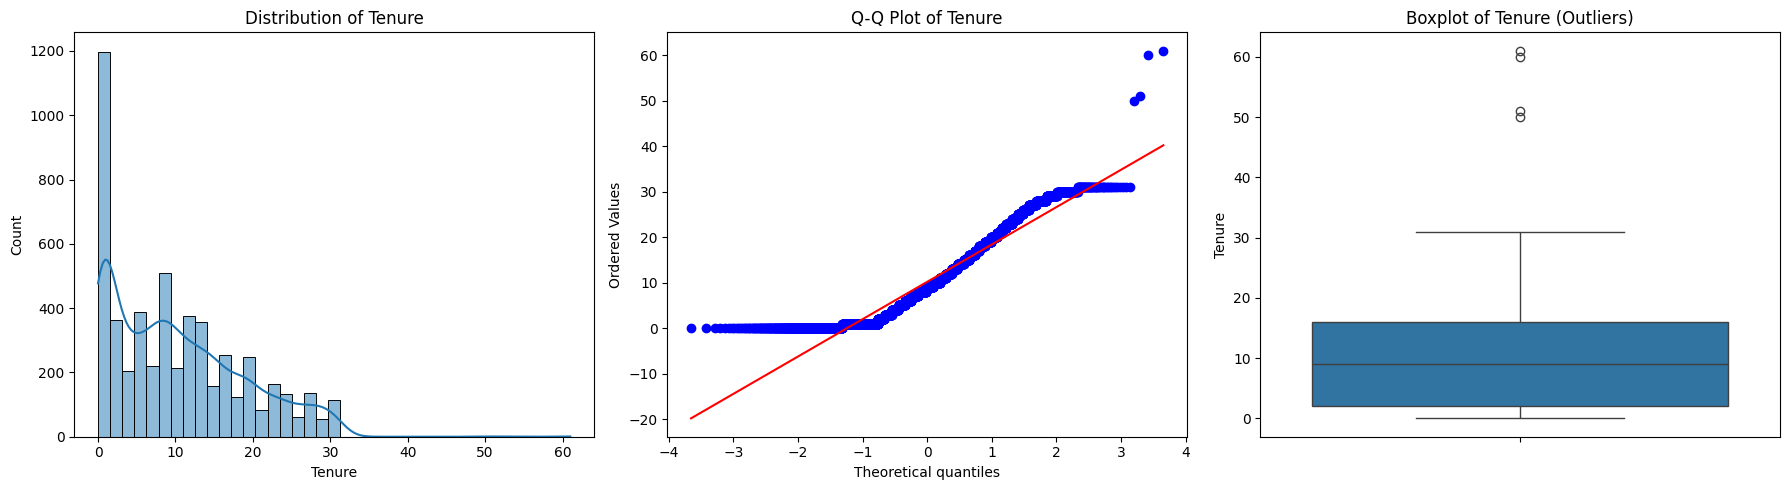

In [200]:
analyze_numerical_feature(df_ecommerce, 'Tenure')


The distribution of customer tenure is **right-skewed**, meaning most customers have a short tenure. The Q-Q plot shows a clear departure from the theoretical quantiles, confirming the non-normal distribution. The boxplot highlights several outliers, representing customers with a very long tenure.

#### WarehouseToHome

==================== Analyzing Numerical Feature: WarehouseToHome ====================



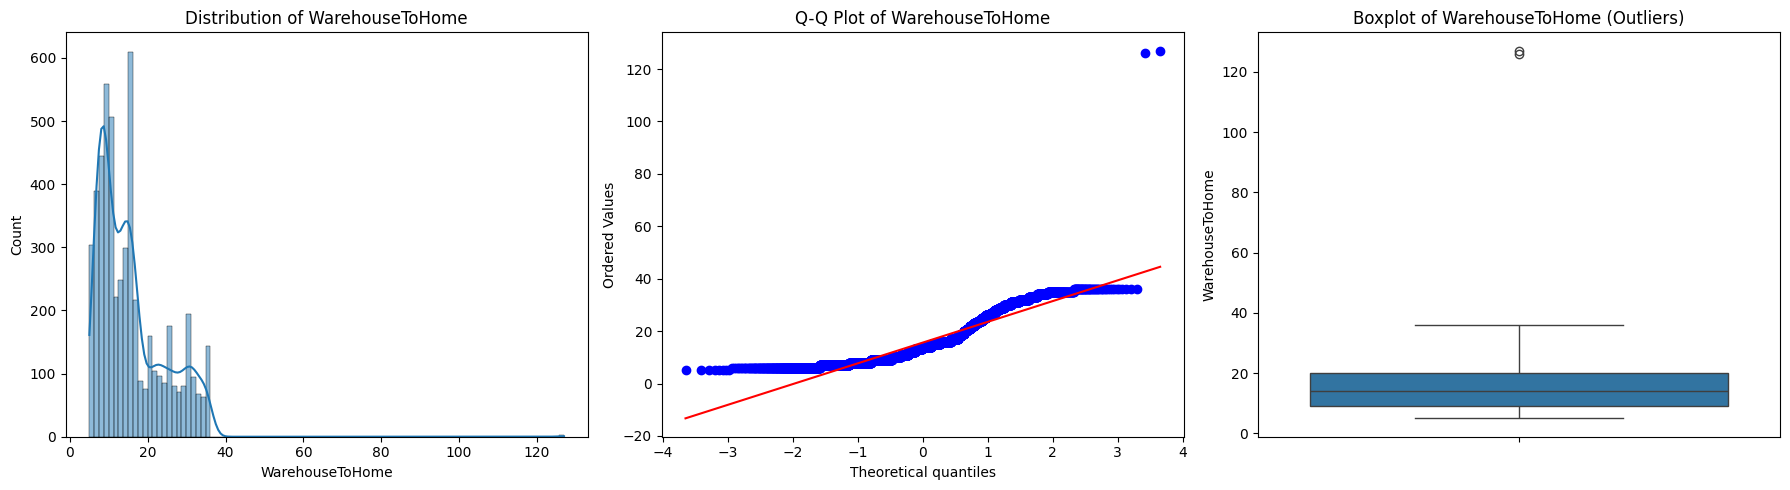

In [201]:
analyze_numerical_feature(df_ecommerce, 'WarehouseToHome')

This distribution is also **right-skewed**, with most customers living relatively close to the warehouse (less than 20 units of distance). The Q-Q plot indicates a non-normal distribution, with the points deviating significantly from the red line. The boxplot shows many outliers, representing customers who live a great distance from the warehouse.


#### HourSpendOnApp

==================== Analyzing Numerical Feature: HourSpendOnApp ====================



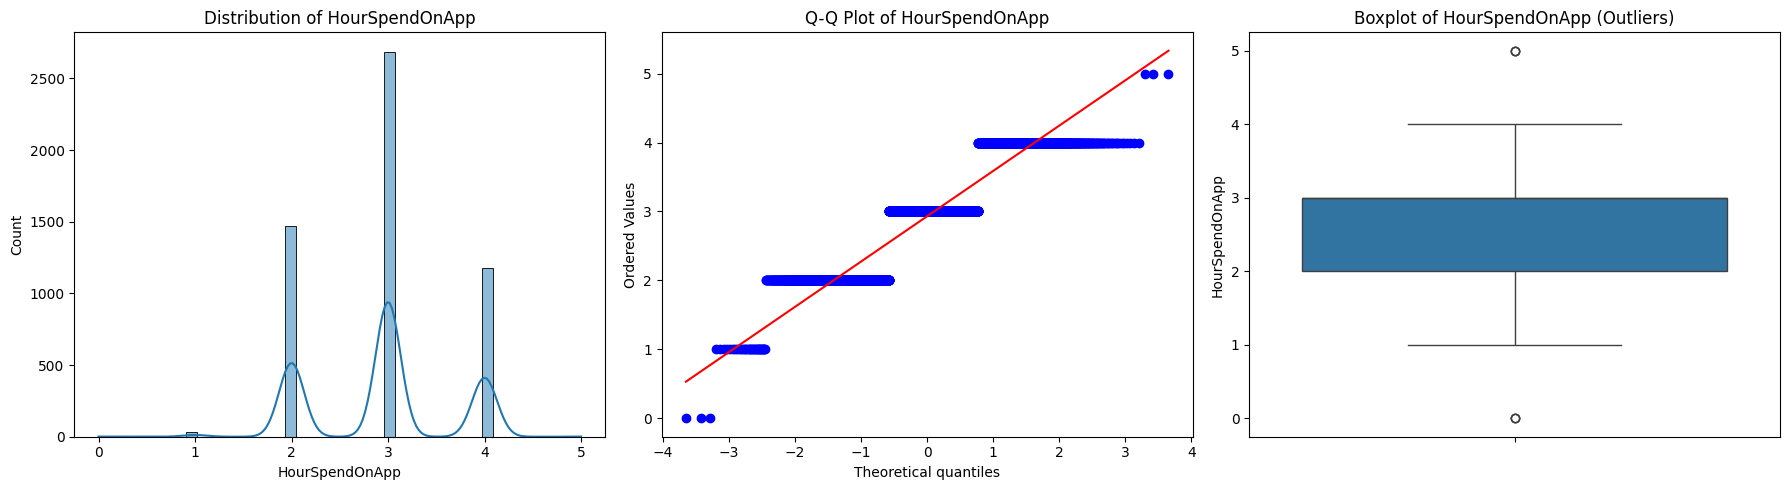

In [202]:
analyze_numerical_feature(df_ecommerce, 'HourSpendOnApp')

The distribution is **multimodal**, with clear peaks at 1, 2, 3, and 4 hours. The most common time spent on the app is 3 hours. The Q-Q plot shows that the data is not normally distributed. The boxplot shows outliers at 0 and 5 hours.

#### NumberOfDeviceRegistered

==================== Analyzing Numerical Feature: NumberOfDeviceRegistered ====================



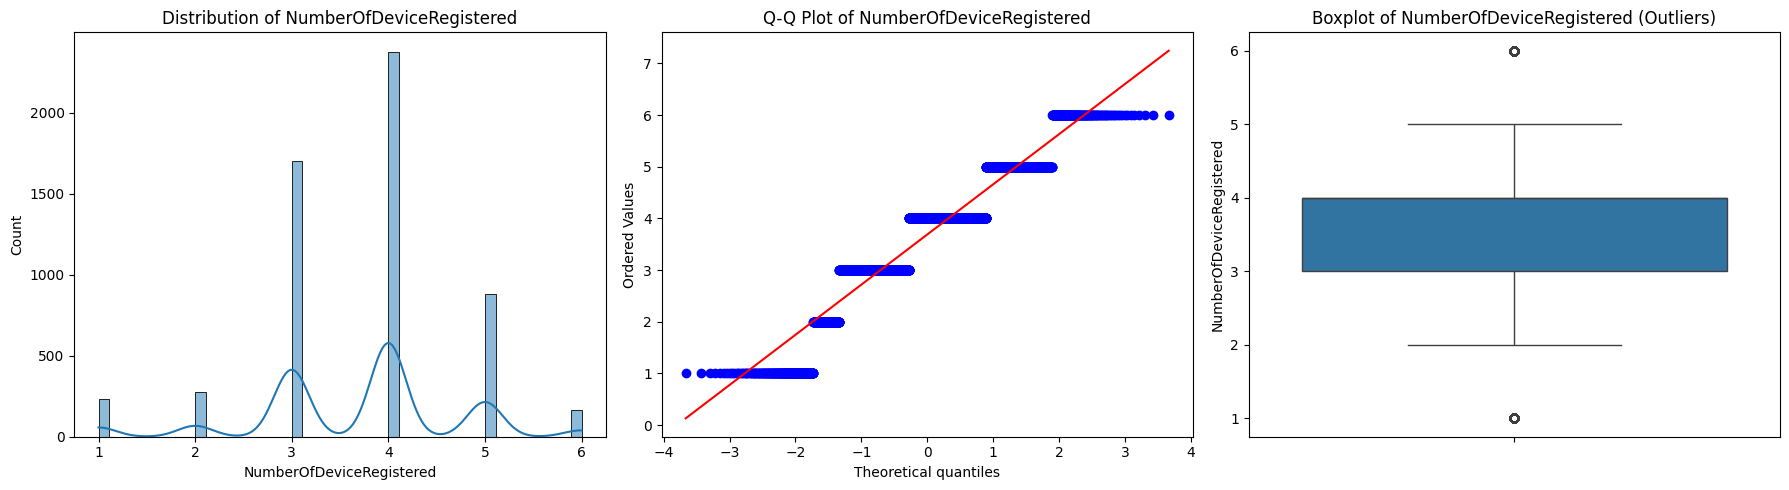

In [203]:
analyze_numerical_feature(df_ecommerce, 'NumberOfDeviceRegistered')

The distribution is **multimodal**, with distinct peaks at 1, 3, 4, 5, and 6 devices. The most common number of devices is 4. The data is not normally distributed, as shown by the Q-Q plot and the distinct peaks in the histogram. The boxplot indicates a few outliers, with a registered device count of 1 and 6.

#### NumberOfAddress

==================== Analyzing Numerical Feature: NumberOfAddress ====================



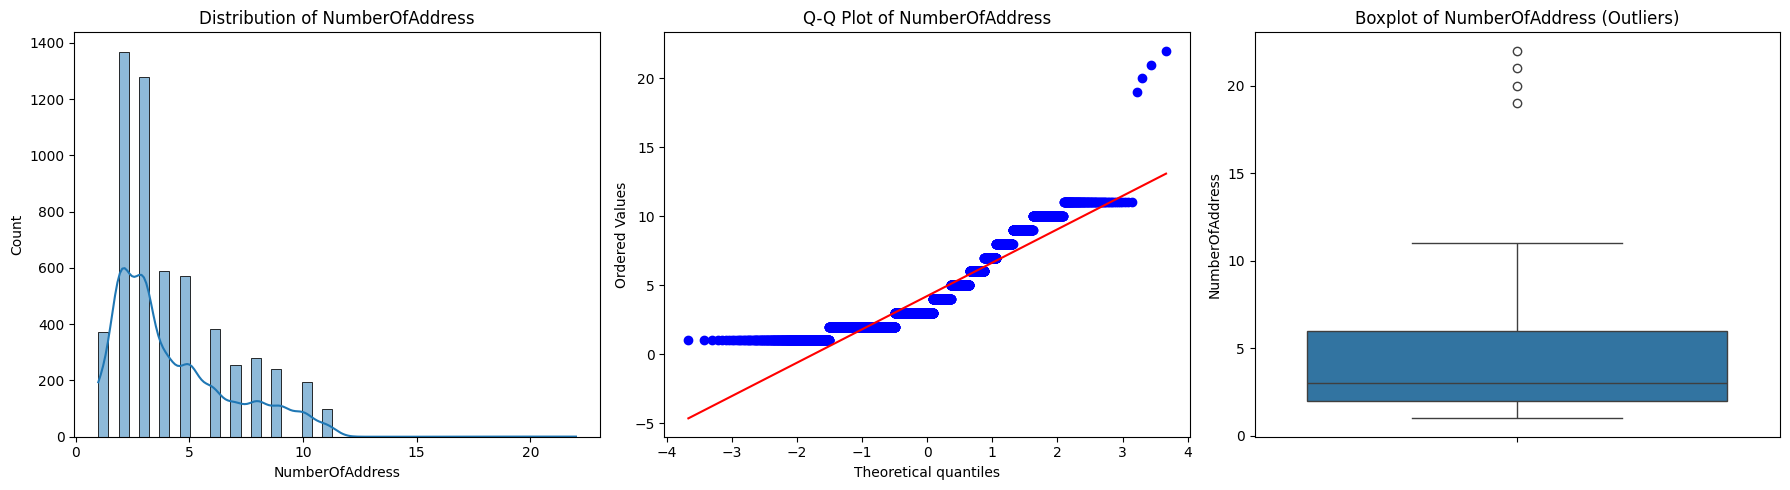

In [204]:
analyze_numerical_feature(df_ecommerce, 'NumberOfAddress')

The data is **heavily right-skewed**, with most customers having a small number of addresses (1 to 5). The frequency of customers decreases significantly as the number of addresses increases. The Q-Q plot and the boxplot with multiple outliers confirm the non-normal and skewed nature of the data.

#### OrderAmountHikeFromlastYear

==================== Analyzing Numerical Feature: OrderAmountHikeFromlastYear ====================



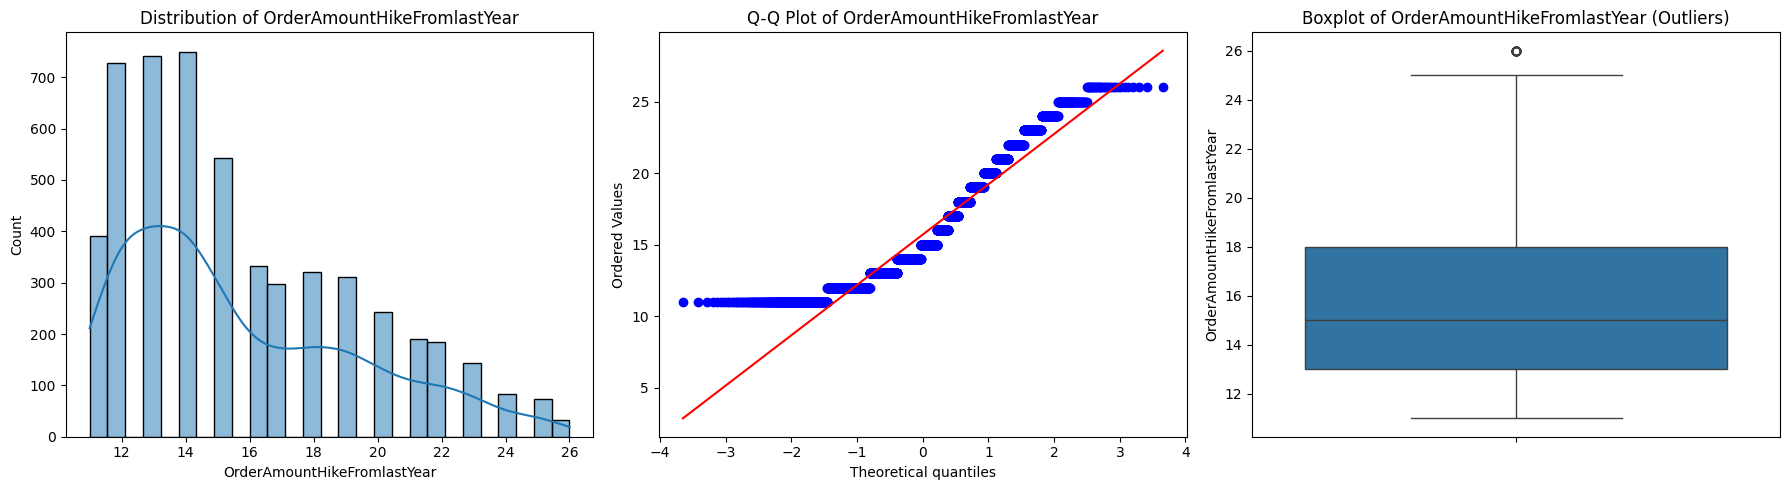

In [205]:
analyze_numerical_feature(df_ecommerce, 'OrderAmountHikeFromlastYear')

The distribution appears **slightly left-skewed**, with a peak around a 14% to 15% increase. The Q-Q plot shows a slight deviation from the normal distribution. The boxplot reveals a few outliers at the upper and lower ends of the range.

#### CouponUsed

==================== Analyzing Numerical Feature: CouponUsed ====================



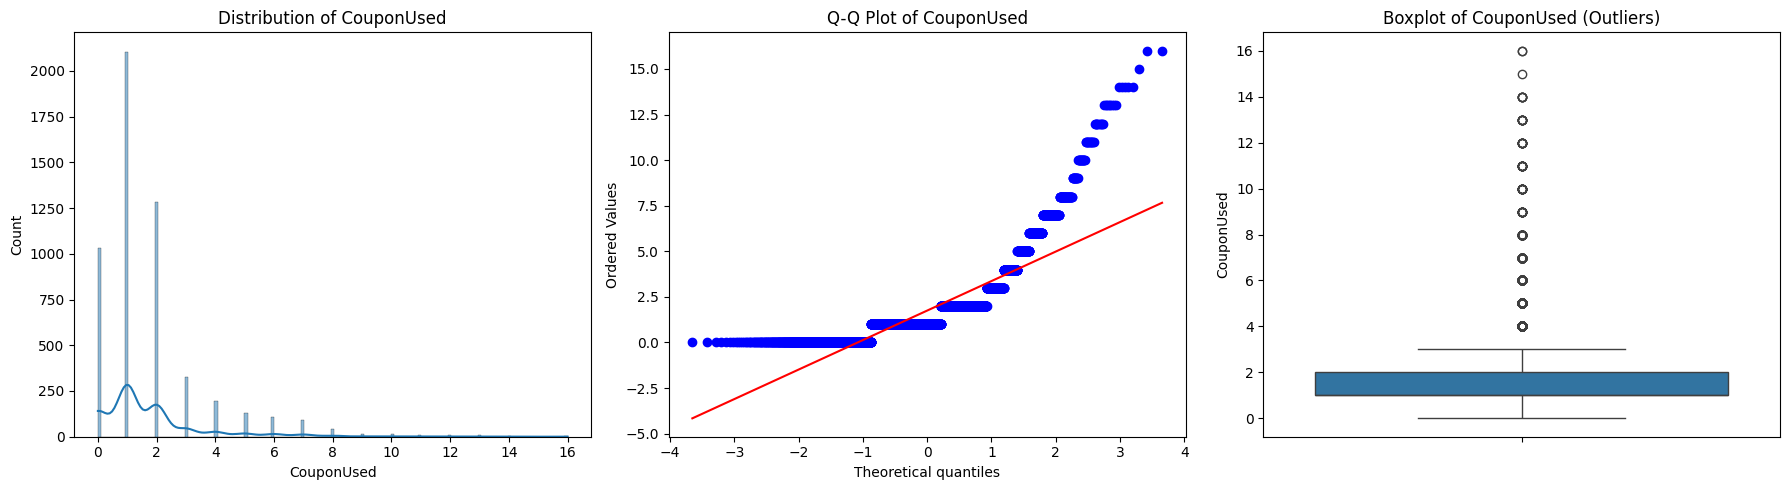

In [206]:
analyze_numerical_feature(df_ecommerce, 'CouponUsed')

The distribution of coupons used is **heavily right-skewed**, with a large majority of customers using 0 or 1 coupon. The number of customers drops dramatically as the number of coupons used increases. The Q-Q plot and the boxplot with many outliers confirm this extreme skewness.

#### OrderCount

==================== Analyzing Numerical Feature: OrderCount ====================



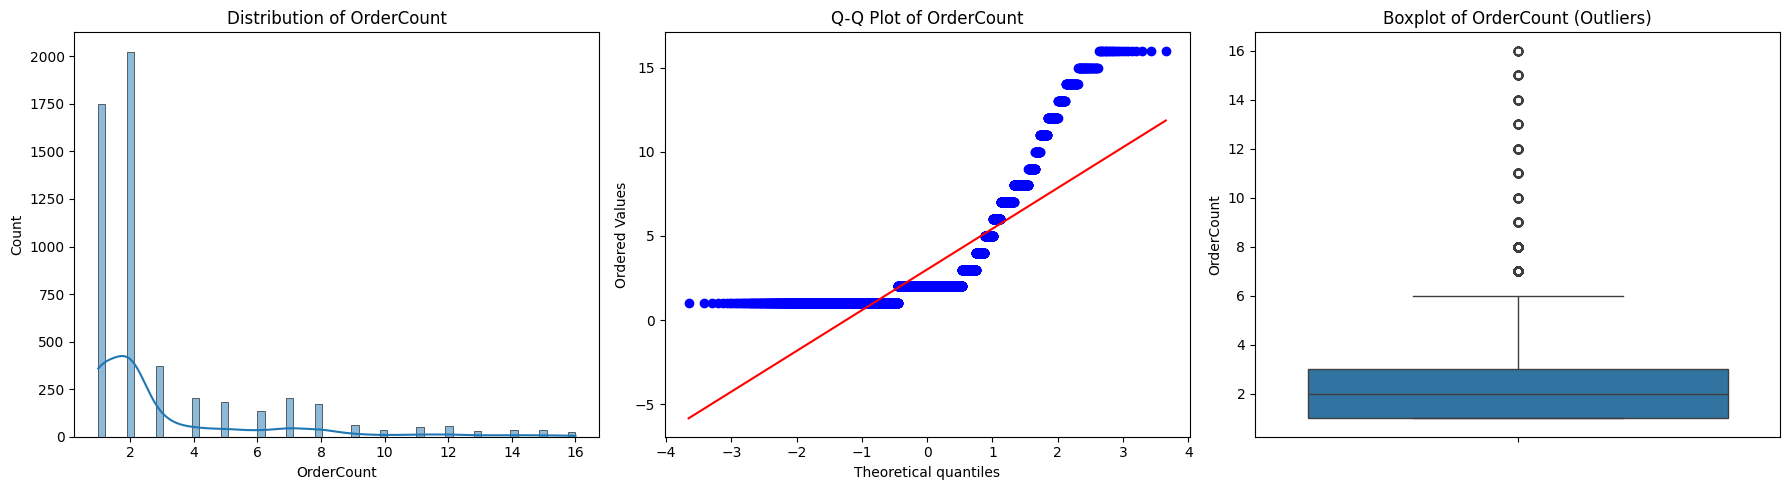

In [207]:
analyze_numerical_feature(df_ecommerce, 'OrderCount')

The data for order count is **heavily right-skewed**, with most customers having a low number of orders (1 or 2). As the order count increases, the frequency of customers drops sharply. The Q-Q plot and the boxplot with numerous outliers confirm this pattern.

#### DaySinceLastOrder

==================== Analyzing Numerical Feature: DaySinceLastOrder ====================



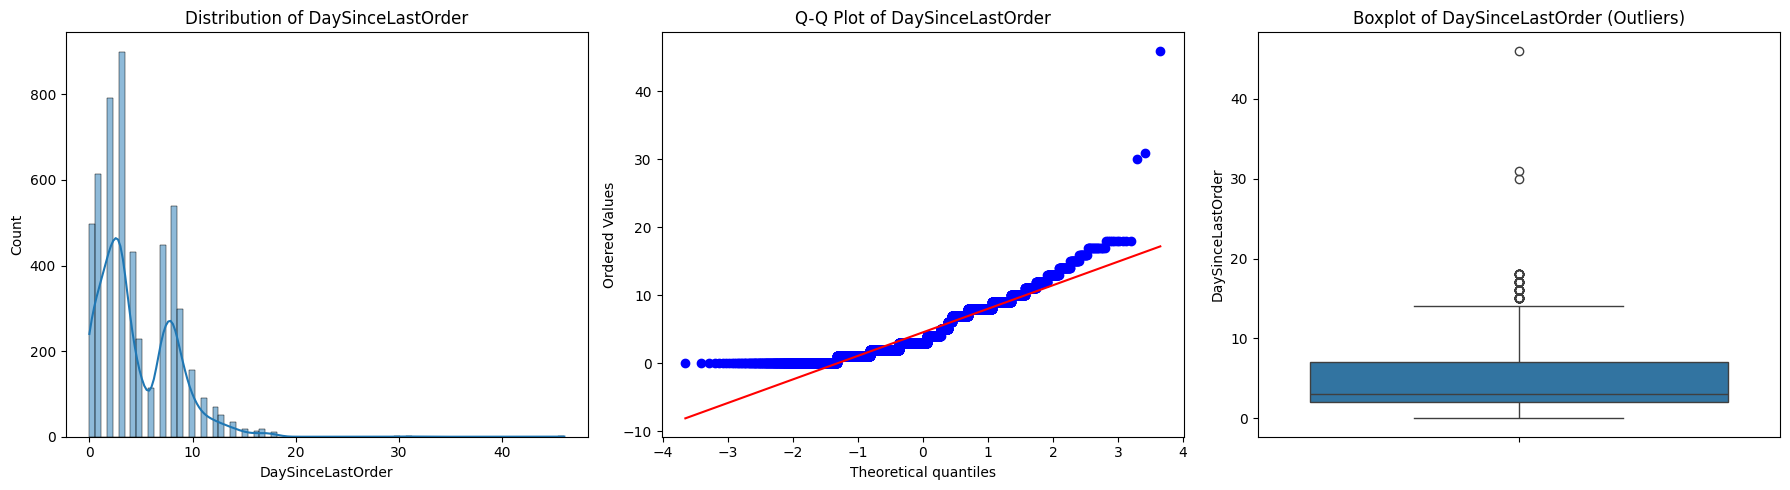

In [208]:
analyze_numerical_feature(df_ecommerce, 'DaySinceLastOrder')

The data is heavily **right-skewed**, indicating that most customers placed an order very recently. The majority of customers last ordered within the first 10 days. The Q-Q plot shows a clear departure from the normal distribution, confirming the skewness. The boxplot reveals numerous outliers, representing customers who haven't ordered in a long time.

#### CashbackAmount

==================== Analyzing Numerical Feature: CashbackAmount ====================



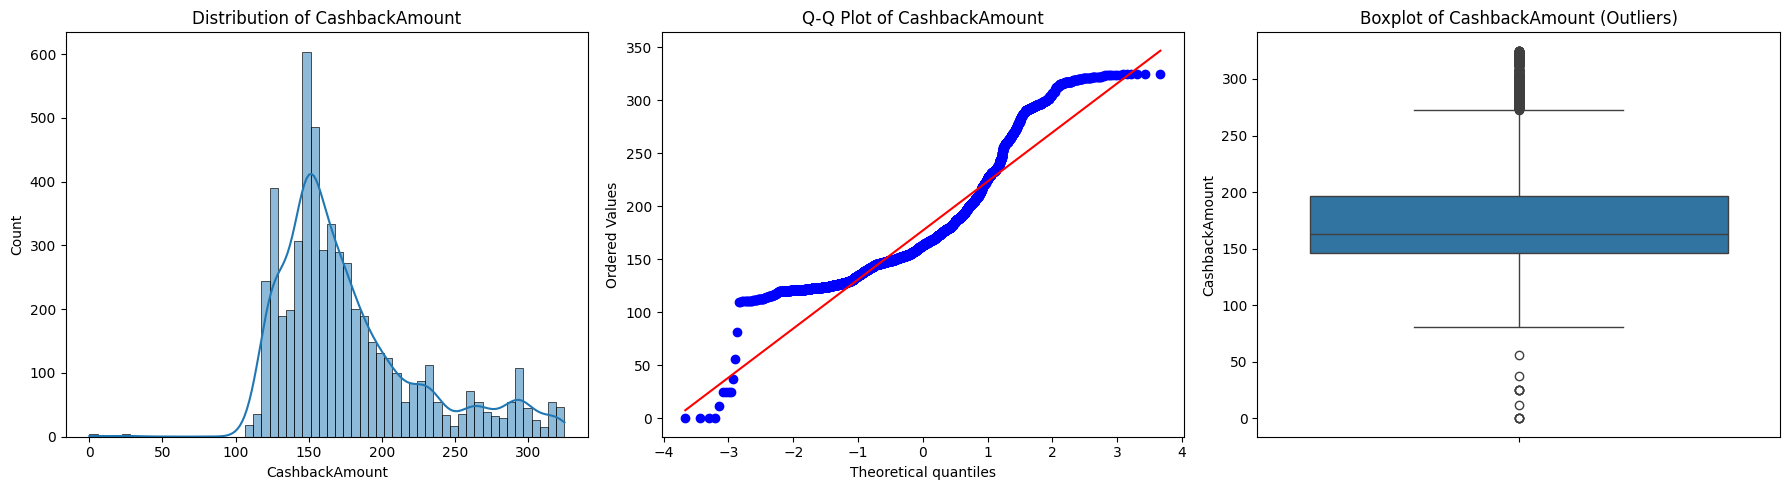

In [209]:
analyze_numerical_feature(df_ecommerce, 'CashbackAmount')

The distribution of cashback amount is **bimodal**, with two peaks. This suggests that there might be two different groups of customers based on their cashback amount. The Q-Q plot confirms that the data is not normally distributed. The boxplot shows several outliers on both the high and low ends.

### 3.5.2. Bivariate Numerical Analysis

In [210]:
def analyze_numerical_by_churn(df, col, target='Churn'):
    """
    Analyze a numerical feature with respect to a binary target (Churn).
    Includes boxplot, histogram with KDE, and appropriate statistical test
    (T-test if normal, Mann-Whitney U if not).
    
    Parameters:
    - df: pandas DataFrame
    - col: column name (string) of numerical feature
    - target: target column name (default 'Churn')
    """
    print(f'{"="*20} Analyzing {col} by {target} {"="*20}\n')
    
    plt.figure(figsize=(14, 6))  # Adjust figure size for two plots
    
    # Boxplot by Churn with distinct colors
    plt.subplot(1, 2, 1)
    sns.boxplot(x=target, y=col, data=df, hue=target, palette='viridis', legend=False)
    plt.title(f'Boxplot of {col} by {target}')
    
    # Histplot with KDE by Churn
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=col, hue=target, kde=True, palette='viridis', multiple="stack")
    plt.title(f'Distribution of {col} by {target} (KDE)')
    
    plt.tight_layout()
    plt.show()

#### Tenure

==================== Analyzing Tenure by Churn ====================



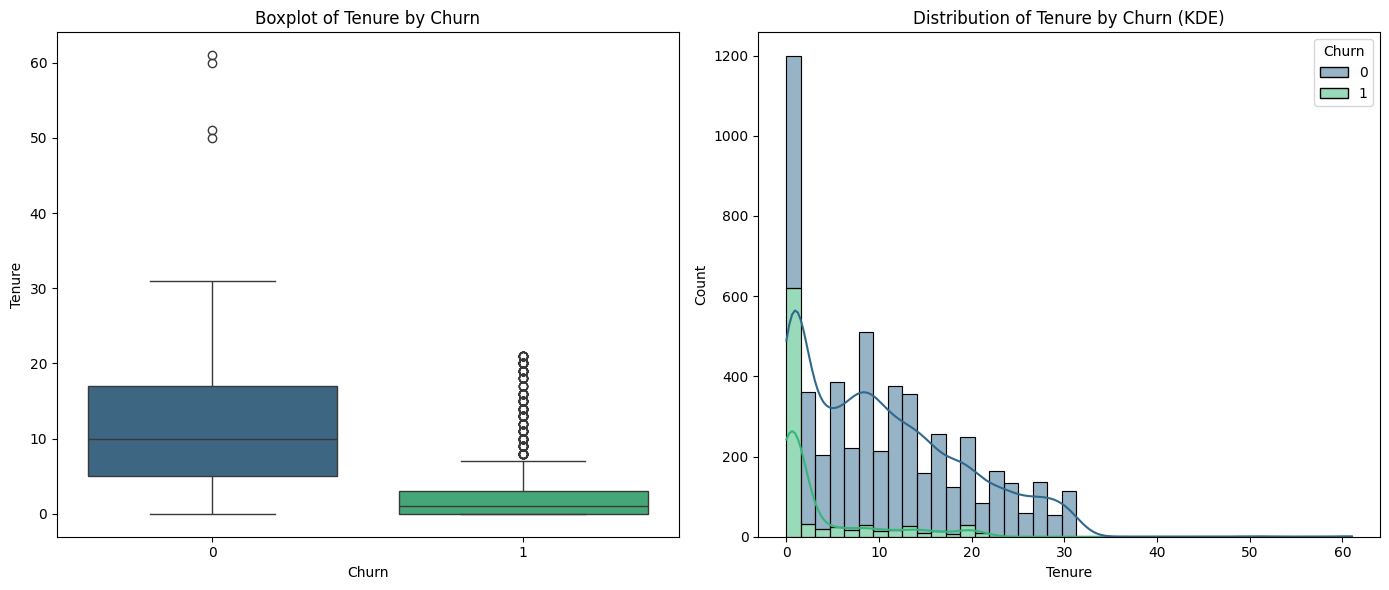

In [211]:
analyze_numerical_by_churn(df_ecommerce, 'Tenure')

There is a **strong relationship** between tenure and churn. The charts show that customers with **short tenure** (less than 5 units) are far more likely to churn than those with longer tenure. The median tenure for non-churning customers is significantly higher than for churning customers.

#### WarehouseToHome

==================== Analyzing WarehouseToHome by Churn ====================



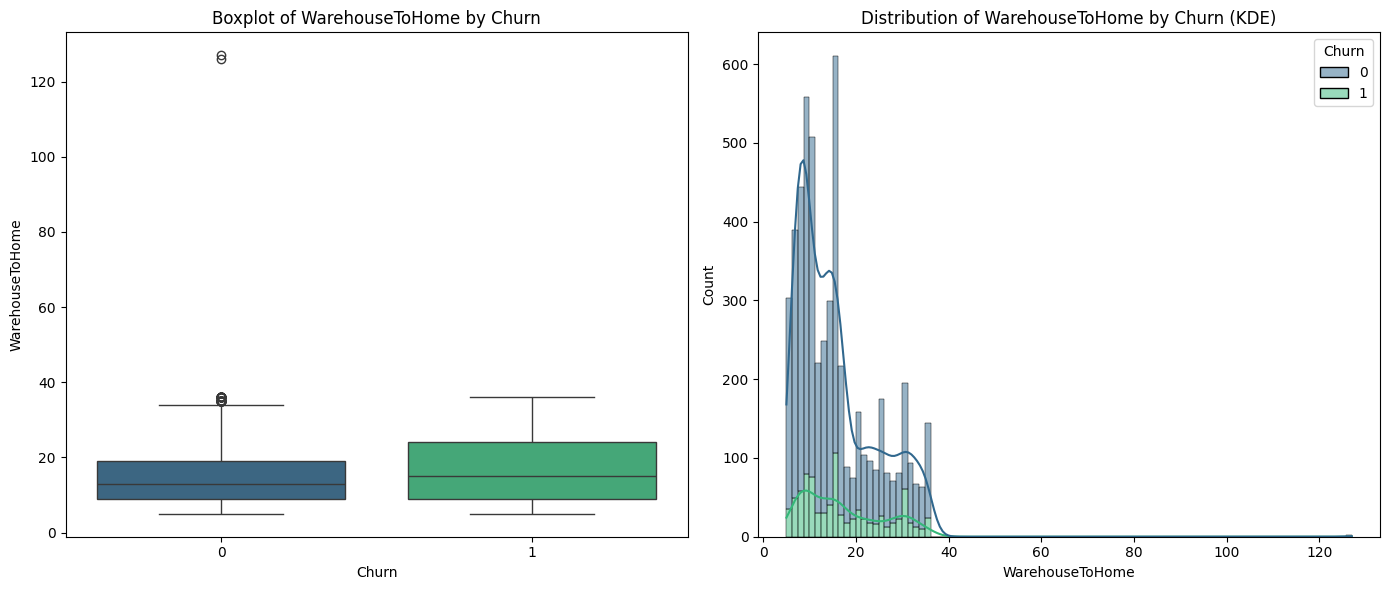

In [212]:
analyze_numerical_by_churn(df_ecommerce, 'WarehouseToHome')

There isn't a significant difference in the distribution of warehouse-to-home distance between churning and non-churning customers. The medians and overall boxplot ranges are very similar, suggesting this factor may not be a strong predictor of churn.

#### HourSpendOnApp

==================== Analyzing HourSpendOnApp by Churn ====================



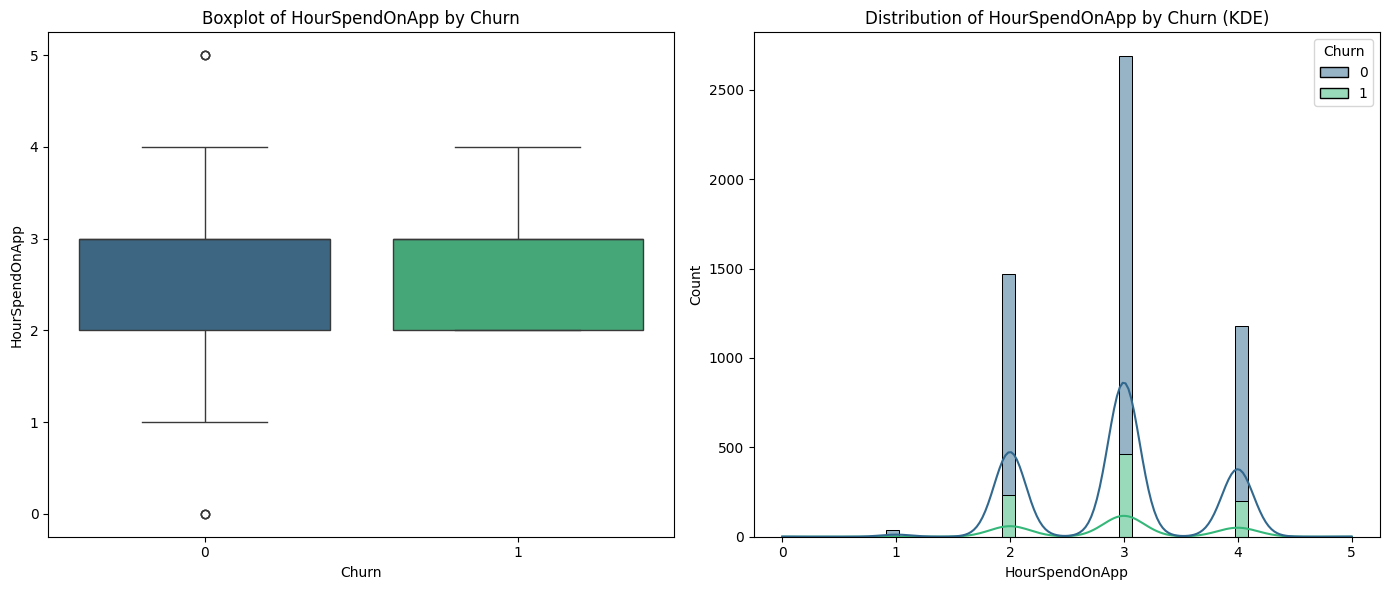

In [213]:
analyze_numerical_by_churn(df_ecommerce, 'HourSpendOnApp')

The distributions are quite similar for both churning and non-churning customers. The boxplots show very similar medians and ranges, suggesting they are **not strong predictors of churn**.

#### NumberOfDeviceRegistered

==================== Analyzing NumberOfDeviceRegistered by Churn ====================



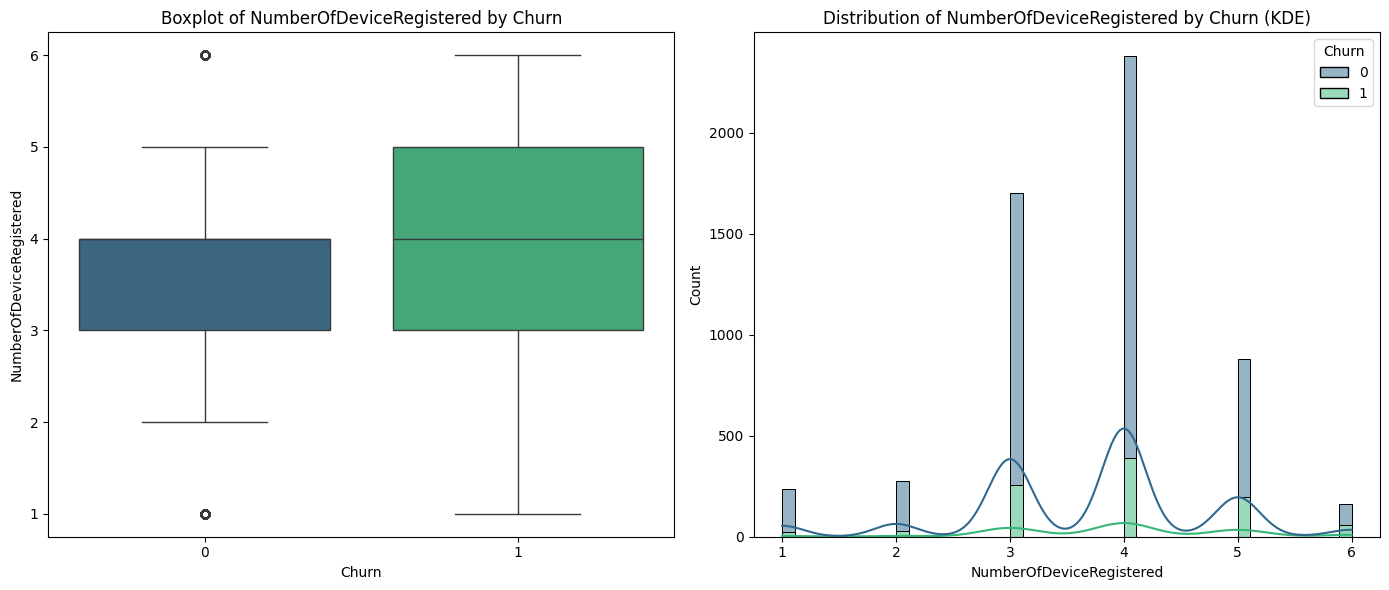

In [214]:
analyze_numerical_by_churn(df_ecommerce, 'NumberOfDeviceRegistered')

Customers who churn tend to have a **higher number of registered devices**. The median number of devices for churning customers is 4, while for non-churning customers it is 3. This could imply that customers with more registered devices are less committed to a single platform.

#### NumberOfAddress

==================== Analyzing NumberOfAddress by Churn ====================



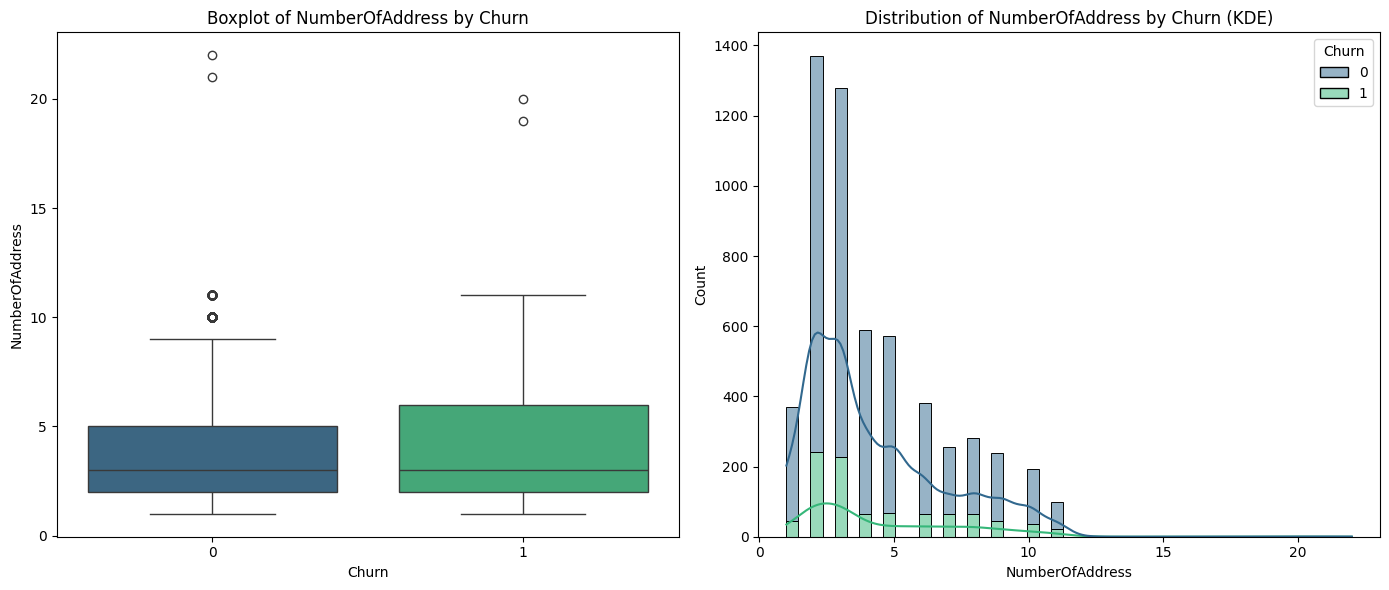

In [215]:
analyze_numerical_by_churn(df_ecommerce, 'NumberOfAddress')

#### OrderAmountHikeFromlastYear

==================== Analyzing OrderAmountHikeFromlastYear by Churn ====================



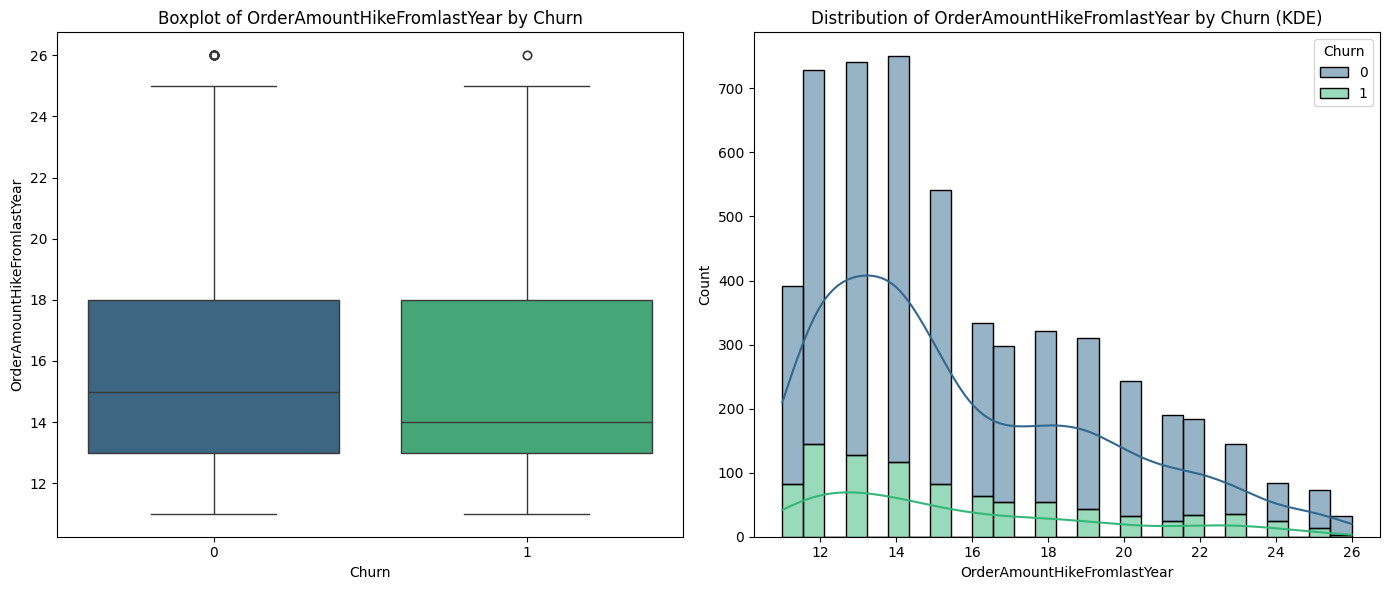

In [216]:
analyze_numerical_by_churn(df_ecommerce, 'OrderAmountHikeFromlastYear')

The distributions are quite similar for both churning and non-churning customers. The boxplots show very similar medians and ranges, suggesting they are **not strong predictors of churn**.

#### CouponUsed

==================== Analyzing CouponUsed by Churn ====================



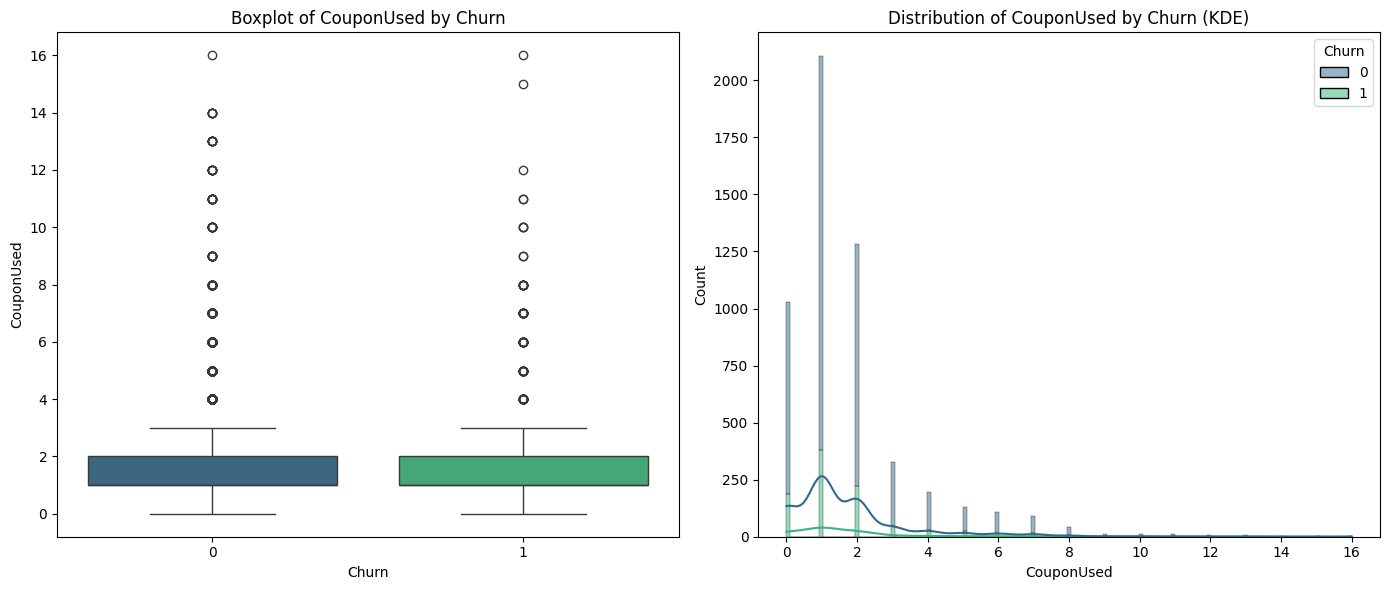

In [217]:
analyze_numerical_by_churn(df_ecommerce, 'CouponUsed')

For coupon used, the distributions are **heavily skewed towards low values** for both churning and non-churning customers. While there are slight differences, neither variable appears to have a strong, clear relationship with churn.

#### OrderCount

==================== Analyzing OrderCount by Churn ====================



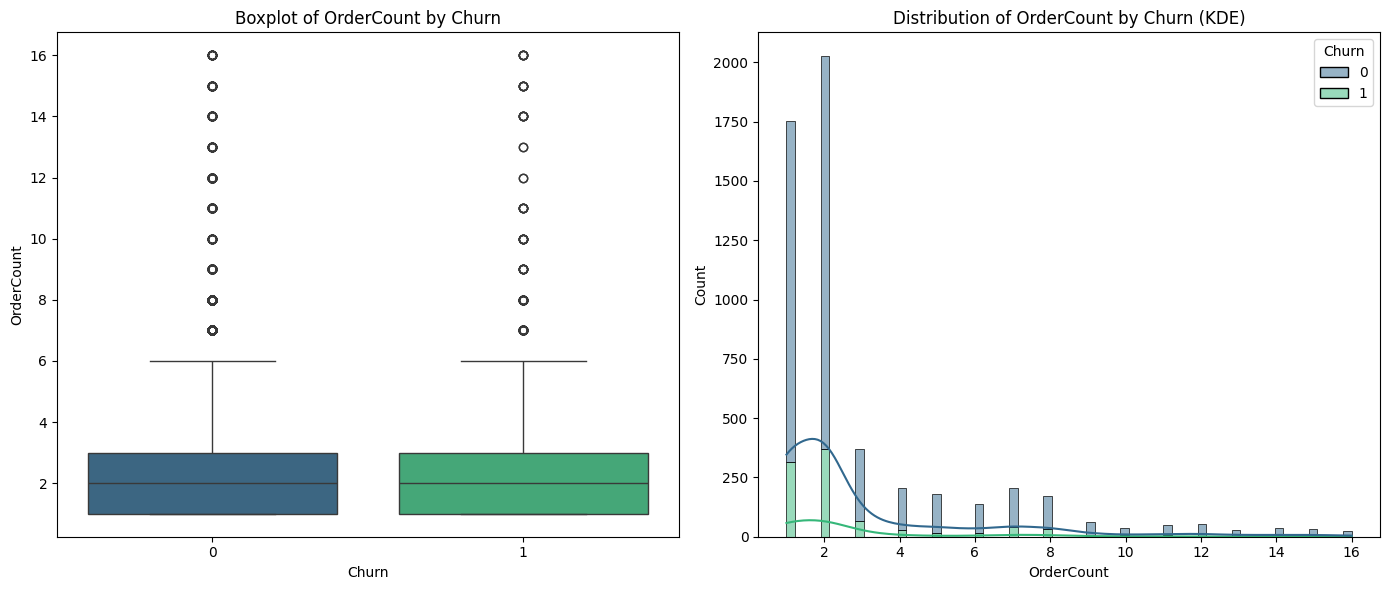

In [218]:
analyze_numerical_by_churn(df_ecommerce, 'OrderCount')

For order count, the distributions are **heavily skewed towards low values** for both churning and non-churning customers. While there are slight differences, neither variable appears to have a strong, clear relationship with churn.

#### DaySinceLastOrder

==================== Analyzing DaySinceLastOrder by Churn ====================



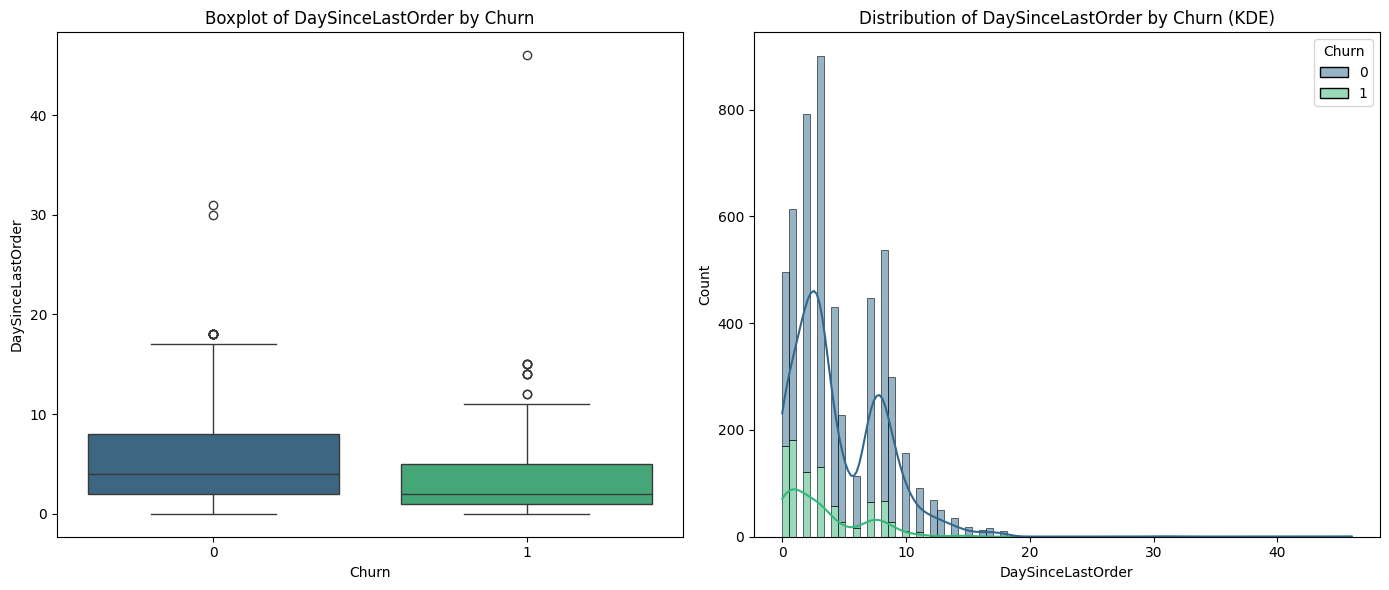

In [219]:
analyze_numerical_by_churn(df_ecommerce, 'DaySinceLastOrder')

Customers who have not churned have a **wider range** of days since their last order, but the majority of churning customers have a very **recent last order** (typically within the first 5 days). This could indicate that customers are leaving shortly after a recent poor experience.

#### CashbackAmount

==================== Analyzing CashbackAmount by Churn ====================



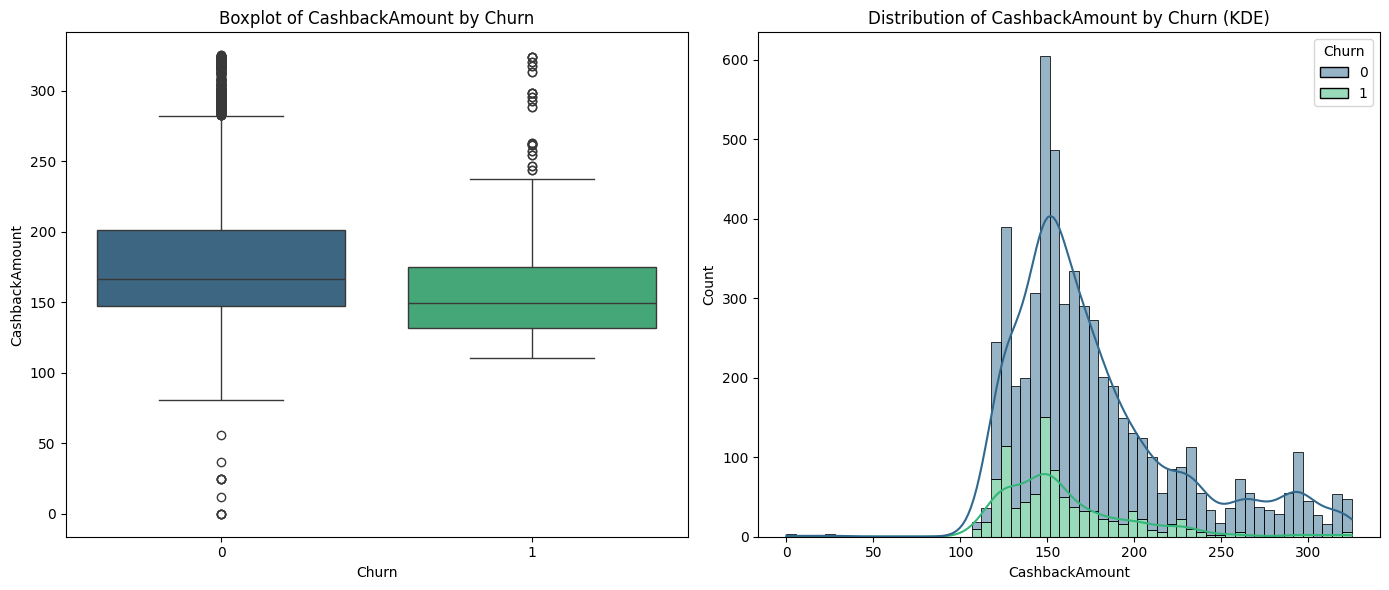

In [220]:
analyze_numerical_by_churn(df_ecommerce, 'CashbackAmount')

The median cashback amount is noticeably **lower** for churning customers compared to non-churning customers. This suggests that a higher cashback amount may be a factor in retaining customers.

## 3.6. In-depth Categorical Analysis

In [221]:
# Define all categorical features to analyze
categorical_features = df_ecommerce.select_dtypes(include='object').columns.tolist()
ordinal_binary_features = ['CityTier', 'SatisfactionScore', 'Complain']
all_categorical = categorical_features + ordinal_binary_features

### 3.6.1. Univariate

In [222]:
def analyze_univariate_categorical(df_ecommerce, all_categorical):
    """
    Analyzes and visualizes each categorical feature in a DataFrame
    by generating a countplot and a pie chart.

    Parameters:
    - df_ecommerce (pd.DataFrame): The input DataFrame.
    - all_categorical (list): A list of categorical column names.
    """
    for col in all_categorical:
        print(f'\nAnalyzing Univariate Feature: {col}')
        
        # Check for "super minority" classes (e.g., less than 1% of the total)
        total_count = len(df_ecommerce[col])
        value_counts = df_ecommerce[col].value_counts(normalize=True)
        minority_classes = value_counts[value_counts < 0.01].index.tolist()
        
        if minority_classes:
            print(f"Warning: The following classes in '{col}' are super minority classes (<1%): {minority_classes}")
            print("Consider grouping these classes for better analysis/modeling.")

        plt.figure(figsize=(18, 7))

        # Subplot 1: Countplot for absolute counts
        plt.subplot(1, 2, 1)
        ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')
        plt.title(f'Count of {col}', fontsize=15)
        plt.xlabel('Count', fontsize=12)
        plt.ylabel(col, fontsize=12)
        for p in ax.patches:
            width = p.get_width()
            plt.text(width + 20, p.get_y() + p.get_height() / 2, f'{int(width)}', va='center')

        # Subplot 2: Pie chart for proportions
        plt.subplot(1, 2, 2)
        counts = df_ecommerce[col].value_counts()
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(counts)))
        plt.title(f'Proportion of {col}', fontsize=15)
        plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
        
        plt.tight_layout()
        plt.show()

#### PreferredLoginDevice


Analyzing Univariate Feature: PreferredLoginDevice


/tmp/ipykernel_7694/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


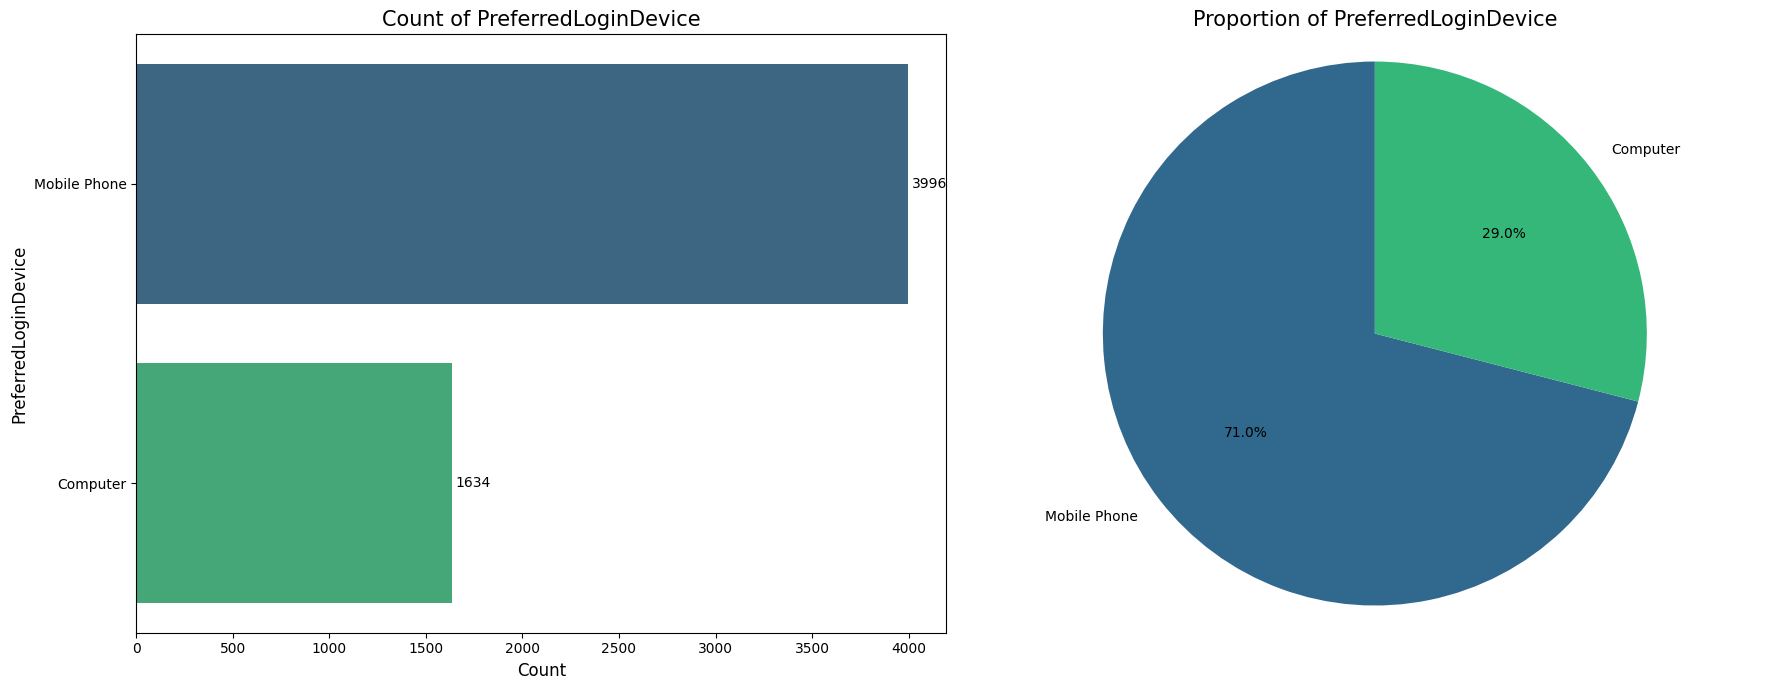

In [223]:
analyze_univariate_categorical(df_ecommerce, ['PreferredLoginDevice'])

- **Mobile Phone dominates (71%)** vs Computer (29%).

#### PreferredPaymentMode


Analyzing Univariate Feature: PreferredPaymentMode


/tmp/ipykernel_7694/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


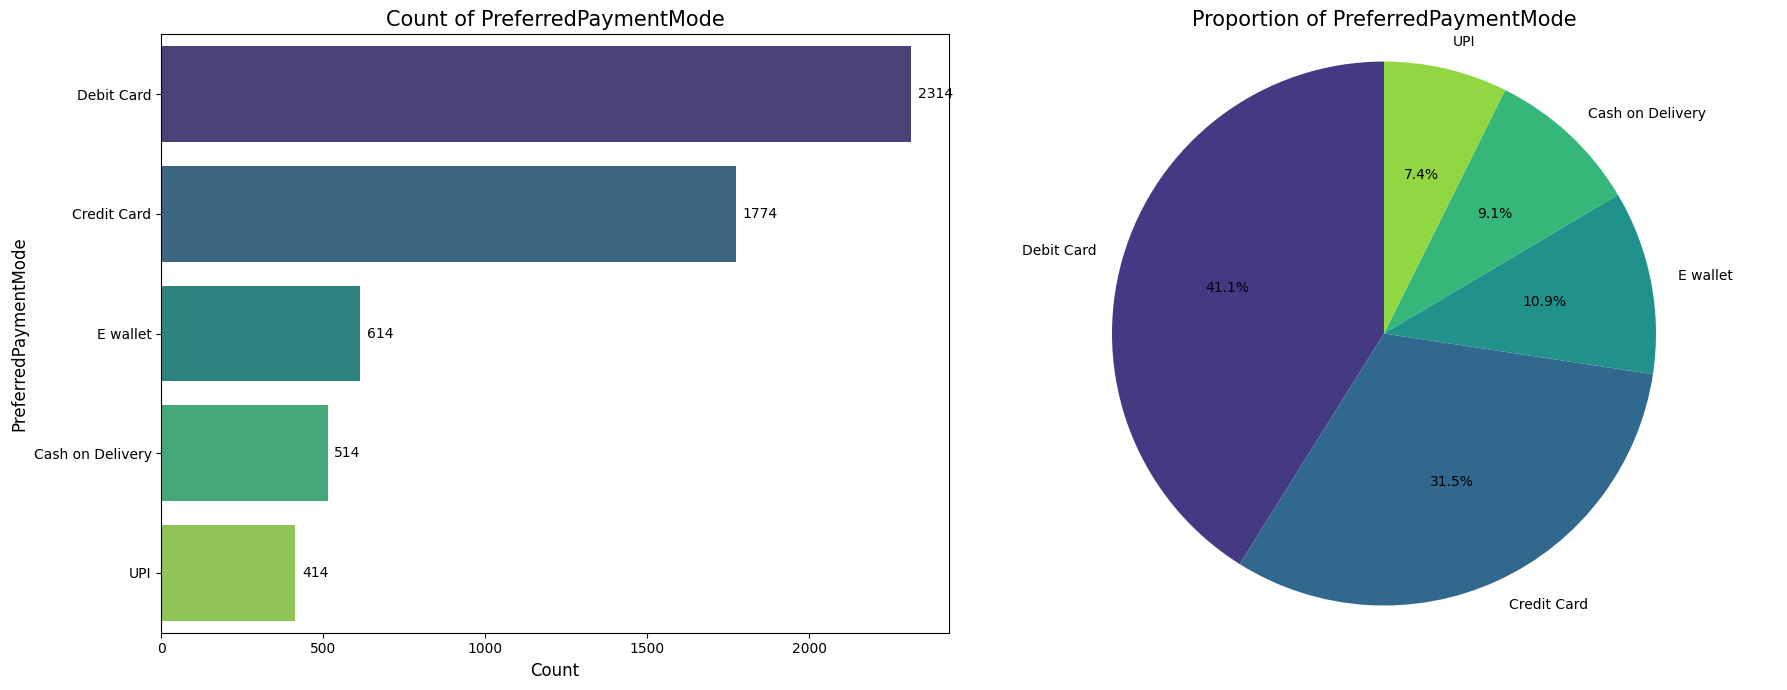

In [224]:
analyze_univariate_categorical(df_ecommerce, ['PreferredPaymentMode'])

- **Debit card leads (41%)**  
- Credit card (32%)  
- Digital wallets (~11%)  
- Cash on Delivery (~9%)  
- UPI (7%)  
➡️ Customers prefer **cards over wallets/UPI**

#### Gender


Analyzing Univariate Feature: Gender


/tmp/ipykernel_7694/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


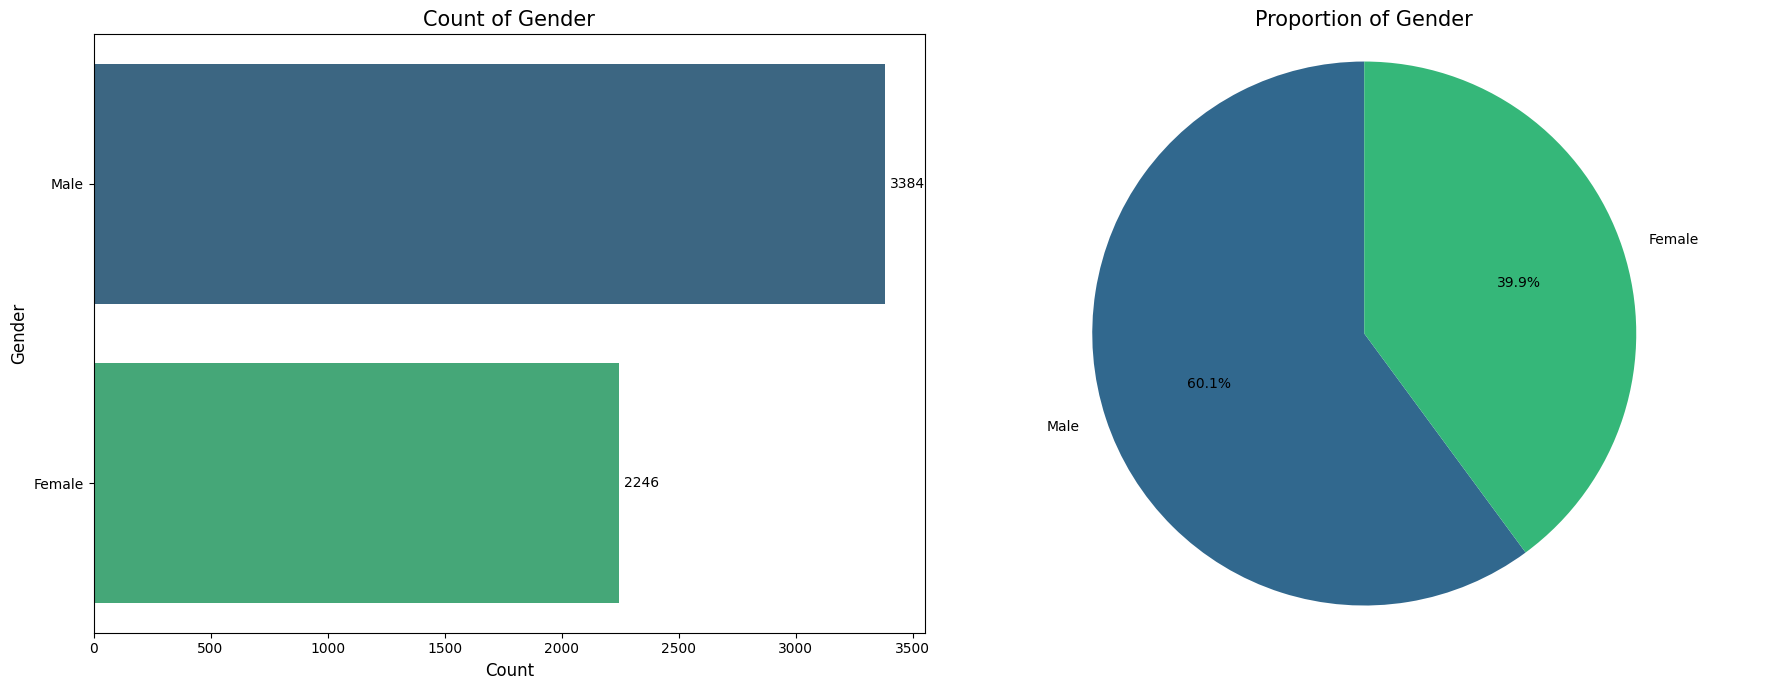

In [225]:
analyze_univariate_categorical(df_ecommerce, ['Gender'])

- Male ~60%  
- Female ~40%  
➡️ A bit male-dominated customer base, but still a significant female segment.

#### PreferedOrderCat


Analyzing Univariate Feature: PreferedOrderCat


/tmp/ipykernel_7694/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


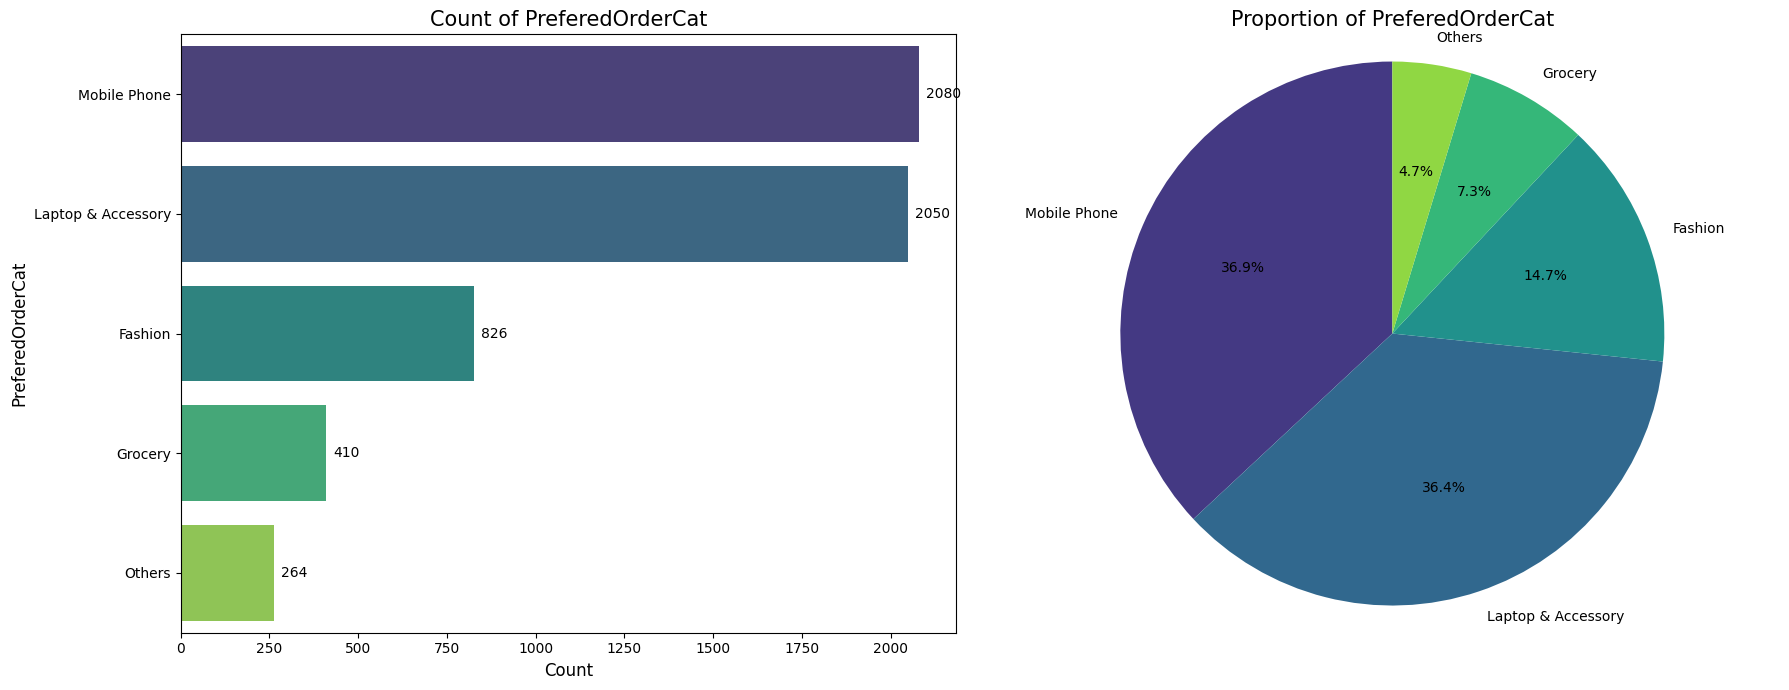

In [226]:
analyze_univariate_categorical(df_ecommerce, ['PreferedOrderCat'])

- **Mobile Phones (37%)**  
- **Laptop & Accessories (36%)**  
- Fashion (~15%)  
- Grocery (~7%)  
- Others (~5%)  
➡️ Electronics dominate; fashion & groceries are **under-penetrated growth opportunities**.

#### MaritalStatus


Analyzing Univariate Feature: MaritalStatus


/tmp/ipykernel_7694/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


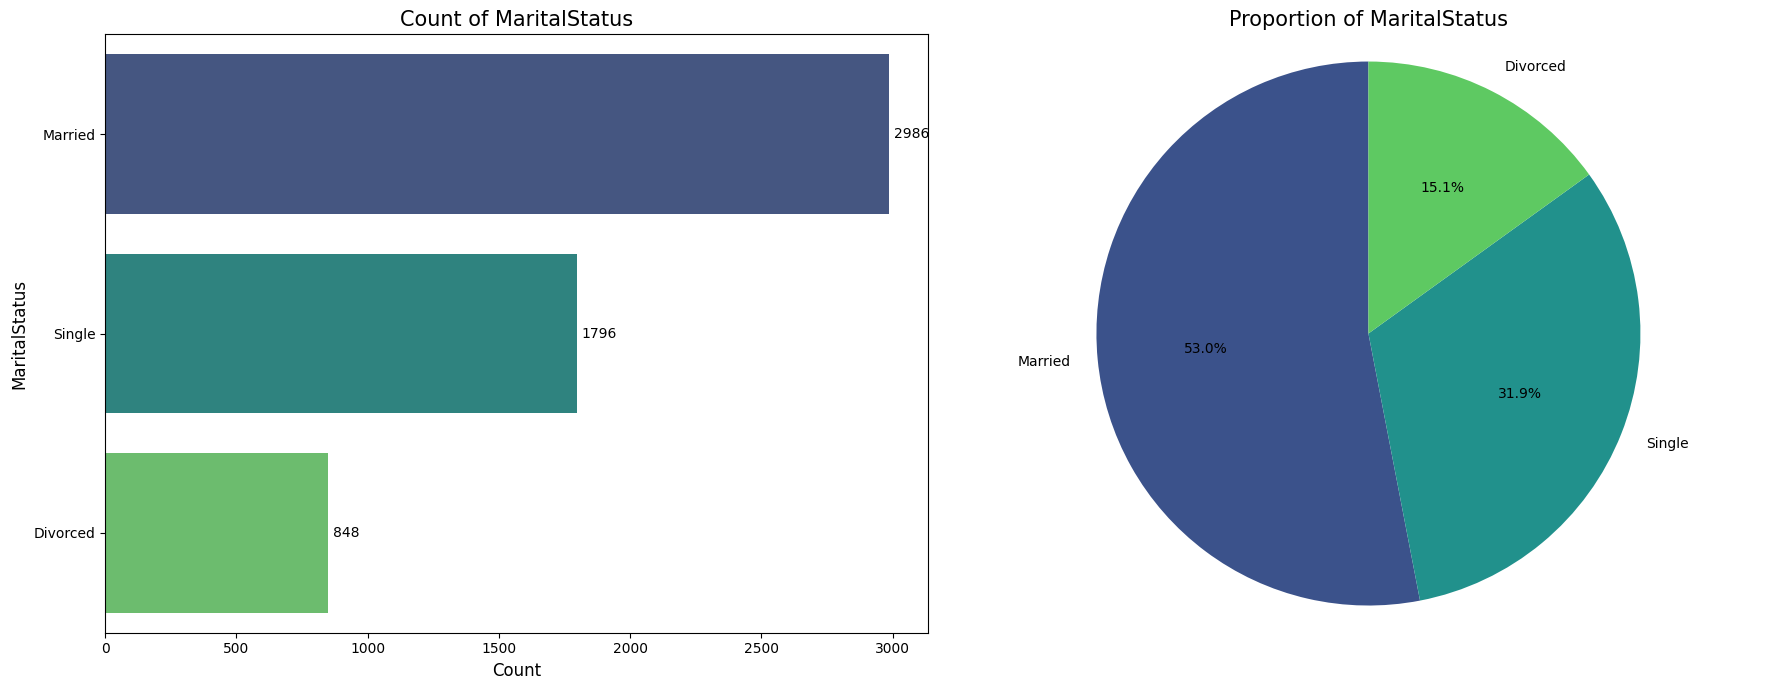

In [227]:
analyze_univariate_categorical(df_ecommerce, ['MaritalStatus'])

- the majority of customers are married, accounting for 53% of the total. Single customers are the next largest group at 31.9%, while divorced customers represent the smallest segment at 15.1%.

#### CityTier


Analyzing Univariate Feature: CityTier


/tmp/ipykernel_7694/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


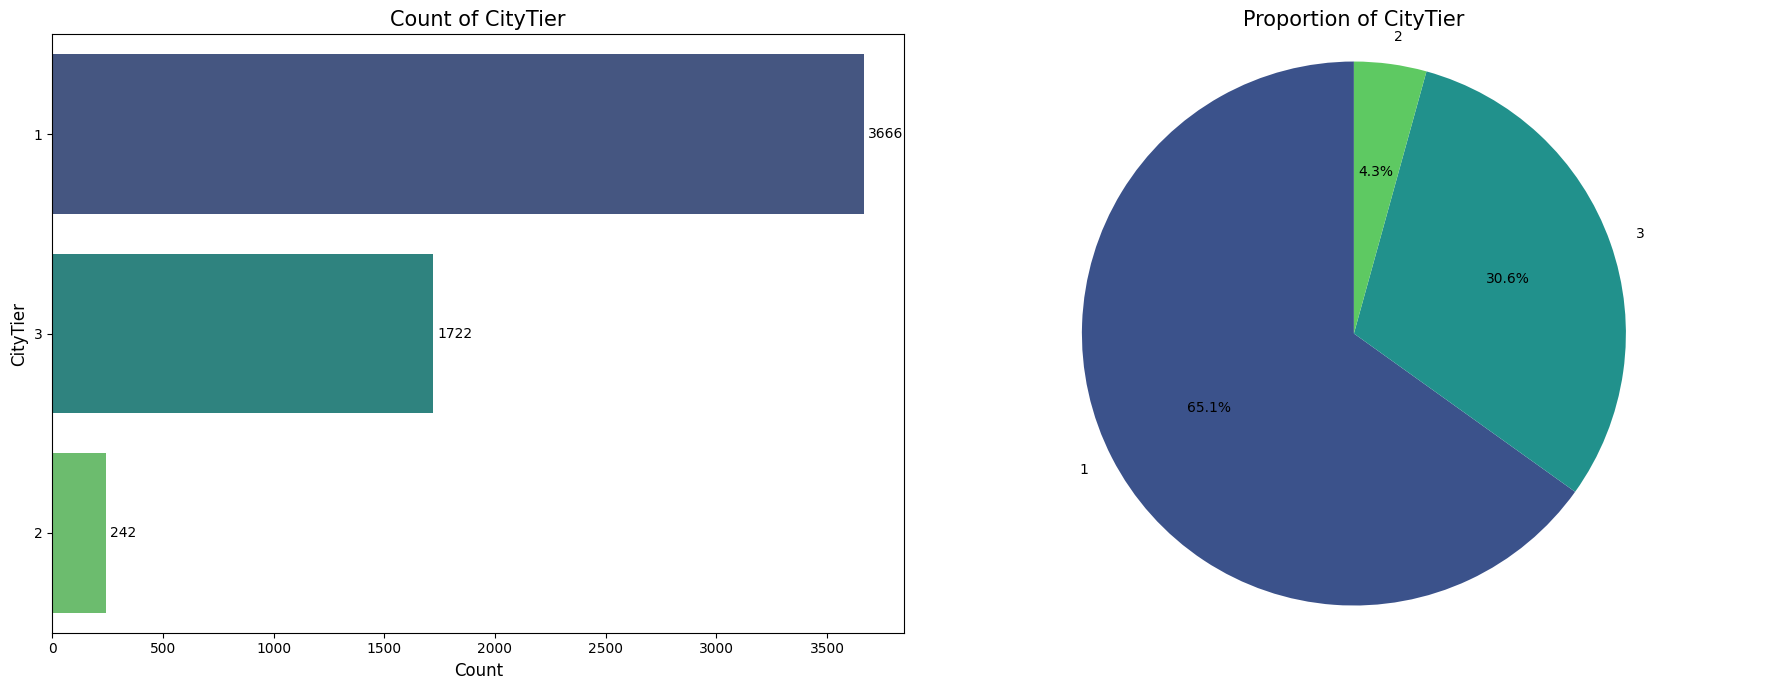

In [228]:
analyze_univariate_categorical(df_ecommerce, ['CityTier'])

- **Tier 1 cities dominate** with ~65% of customers.  
- Tier 3 contributes ~31%, while Tier 2 is very small (~4%).  
➡️ Most customers are concentrated in Tier 1 cities

#### SatisfactionScore


Analyzing Univariate Feature: SatisfactionScore


/tmp/ipykernel_7694/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


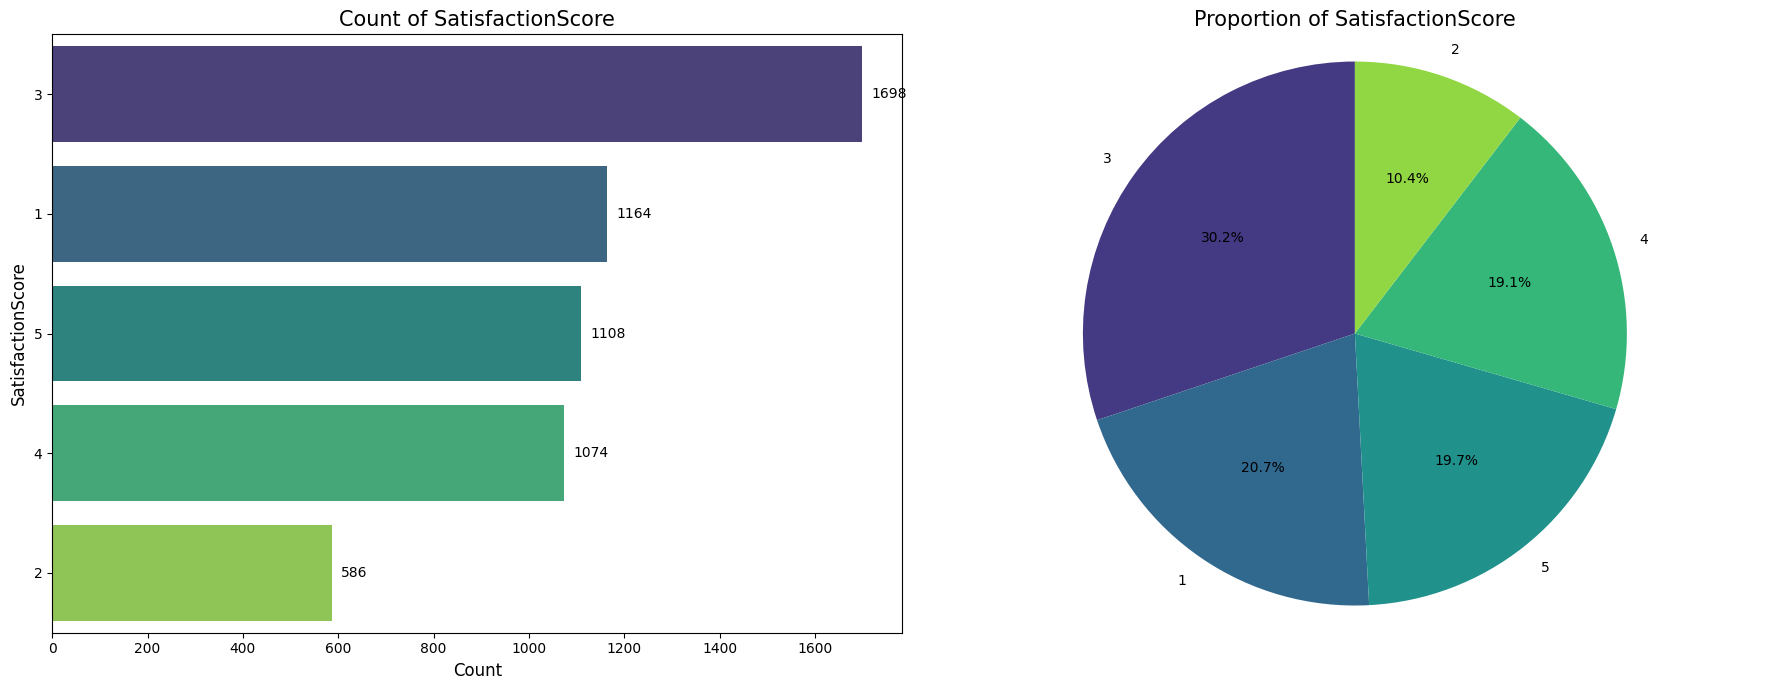

In [229]:
analyze_univariate_categorical(df_ecommerce, ['SatisfactionScore'])

- Score **3 is the most common** (~30%), suggesting many customers are neutral.

#### Complain


Analyzing Univariate Feature: Complain


/tmp/ipykernel_7694/501705266.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


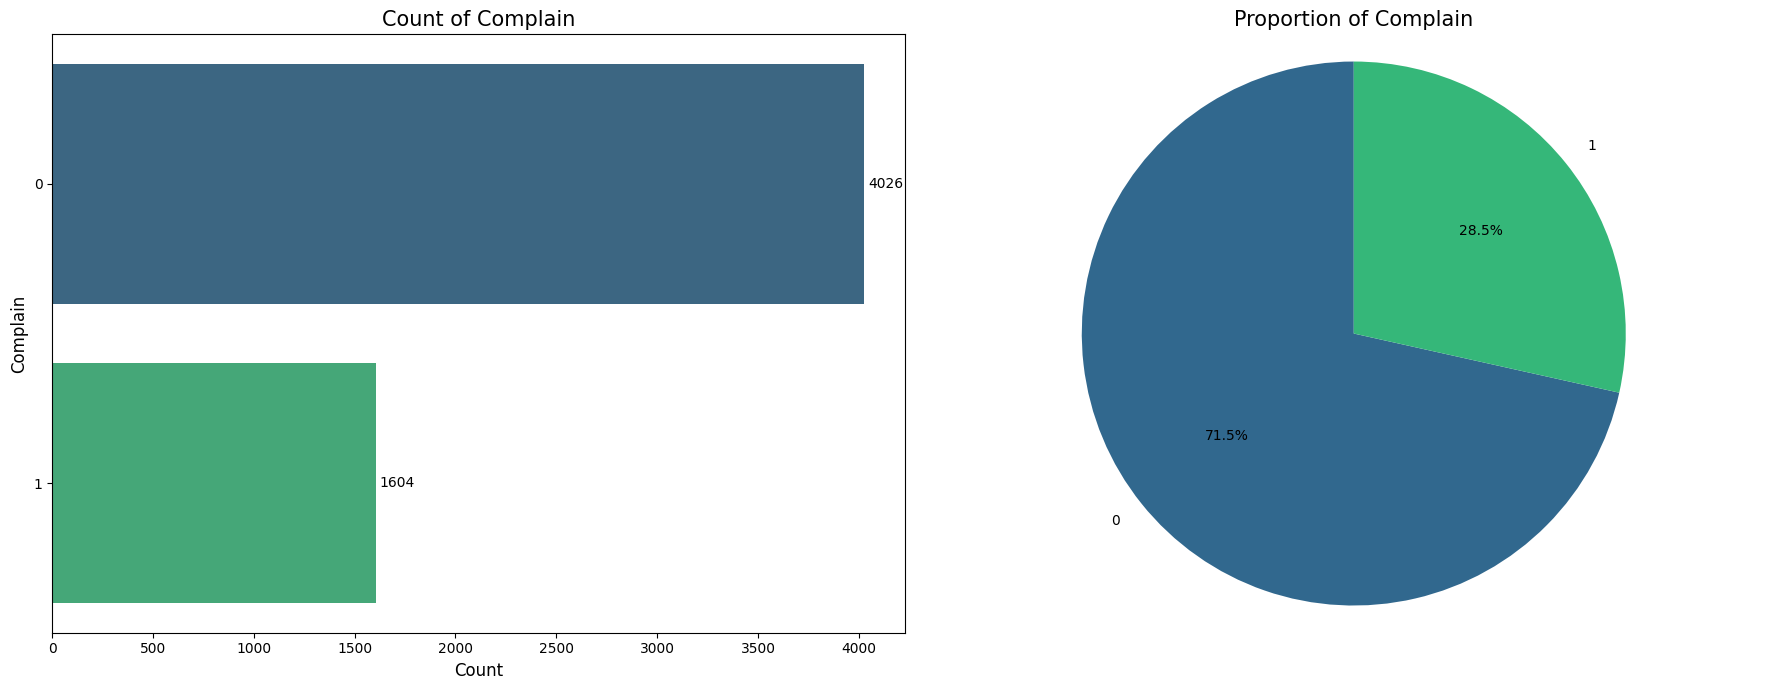

In [230]:
analyze_univariate_categorical(df_ecommerce, ['Complain'])

- **71% have not complained**, but **29% have**.

➡️ A relatively high complaint rate

### 3.6.2. Bivariate

In [231]:
def analyze_bivariate_categorical(df_ecommerce, all_categorical):
    """
    Performs bivariate analysis between categorical features and the 'Churn' target.
    
    For each categorical column, it generates:
    - A stacked bar chart showing the proportion of Churn for each category.
    - A countplot showing the absolute counts of Churn and No Churn for each category.
    - A Chi-squared test to determine if there is a statistically significant association.

    Parameters:
    - df_ecommerce (pd.DataFrame): The input DataFrame containing the features and 'Churn' column.
    - all_categorical (list): A list of categorical column names to analyze.
    """
    # Label + color mapping (don’t modify df, just for plotting)
    label_map = {0: "No Churn", 1: "Churn"}
    complain_map = {0: "No", 1: "Yes"}
    
    # Flexible palette: works with both raw and mapped values
    palette = {
        0: "#42a5f5",   # No Churn (numeric)
        1: "#ef5350",   # Churn (numeric)
        "No": "#42a5f5",
        "Yes": "#ef5350",
        "No Churn": "#42a5f5",
        "Churn": "#ef5350"
    }

    for col in all_categorical:
        print(f'\nAnalyzing Bivariate Feature: {col} vs. Churn')

        # If column is Complain, create a copy with mapped labels
        if col == "Complain":
            df_plot = df_ecommerce.copy()
            df_plot[col] = df_plot[col].map(complain_map)
        else:
            df_plot = df_ecommerce

        # --- Proportion table ---
        churn_proportion = (
            df_plot.groupby(col)['Churn']
            .value_counts(normalize=True)
            .unstack()
            .fillna(0)
        )

        # Rename columns just for plotting
        churn_proportion = churn_proportion.rename(columns=label_map)

        # Ensure both churn categories exist
        for cat in ["Churn", "No Churn"]:
            if cat not in churn_proportion.columns:
                churn_proportion[cat] = 0

        # Reorder so Churn is bottom
        churn_proportion = churn_proportion[["Churn", "No Churn"]]

        # Sort by churn rate
        churn_proportion = churn_proportion.sort_values(by="Churn", ascending=False)

        # --- Subplots ---
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # --- 1. Stacked bar (proportions) ---
        churn_proportion.plot(
            kind="bar",
            stacked=True,
            color=[palette["Churn"], palette["No Churn"]],
            ax=axes[0]
        )

        axes[0].set_title(f'Proportion of Churn by {col}', fontsize=14)
        axes[0].set_xlabel(col, fontsize=12)
        axes[0].set_ylabel('Proportion (%)', fontsize=12)
        axes[0].set_ylim(0, 1)
        axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])
        axes[0].legend(title='Churn', labels=["Churn", "No Churn"])

        # Add percentage labels
        for container in axes[0].containers:
            labels = [f'{v.get_height():.0%}' if v.get_height() > 0 else '' for v in container]
            axes[0].bar_label(container, labels=labels, label_type='center', fontsize=9)

        # --- 2. Countplot (sorted by churn count) ---
        churn_counts = (
            df_plot.groupby(col)["Churn"]
            .value_counts()
            .unstack(fill_value=0)
        )

        # Sort categories by descending churn count
        order_by_churn = churn_counts.sort_values(1, ascending=False).index

        ax = sns.countplot(
            data=df_plot,
            x=col,
            hue="Churn",
            order=order_by_churn,
            palette=palette,
            ax=axes[1]
        )

        # Fix legend labels
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [label_map.get(int(lbl), lbl) for lbl in labels]
        ax.legend(handles, new_labels, title="Churn")

        ax.set_title(f"Count of {col} by Churn", fontsize=14)
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel("Count", fontsize=12)
        ax.tick_params(axis="x", rotation=45)

        # Add count labels
        for container in ax.containers:
            ax.bar_label(container, fmt="%d", fontsize=9)

        plt.tight_layout()
        plt.show()

        # Chi-squared Test for Association
        contingency_table = pd.crosstab(df_ecommerce[col], df_ecommerce['Churn'])
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        
        print(f'Chi-squared Test for {col}: Chi2-statistic={chi2:.3f}, p-value={p:.3f}')
        
        if p < 0.05:
            print(f'Conclusion: There is a statistically significant association between {col} and Churn.')
        else:
            print(f'Conclusion: There is no statistically significant association between {col} and Churn.')
            
        print("-" * 50)

#### PreferredLoginDevice


Analyzing Bivariate Feature: PreferredLoginDevice vs. Churn


/tmp/ipykernel_7694/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


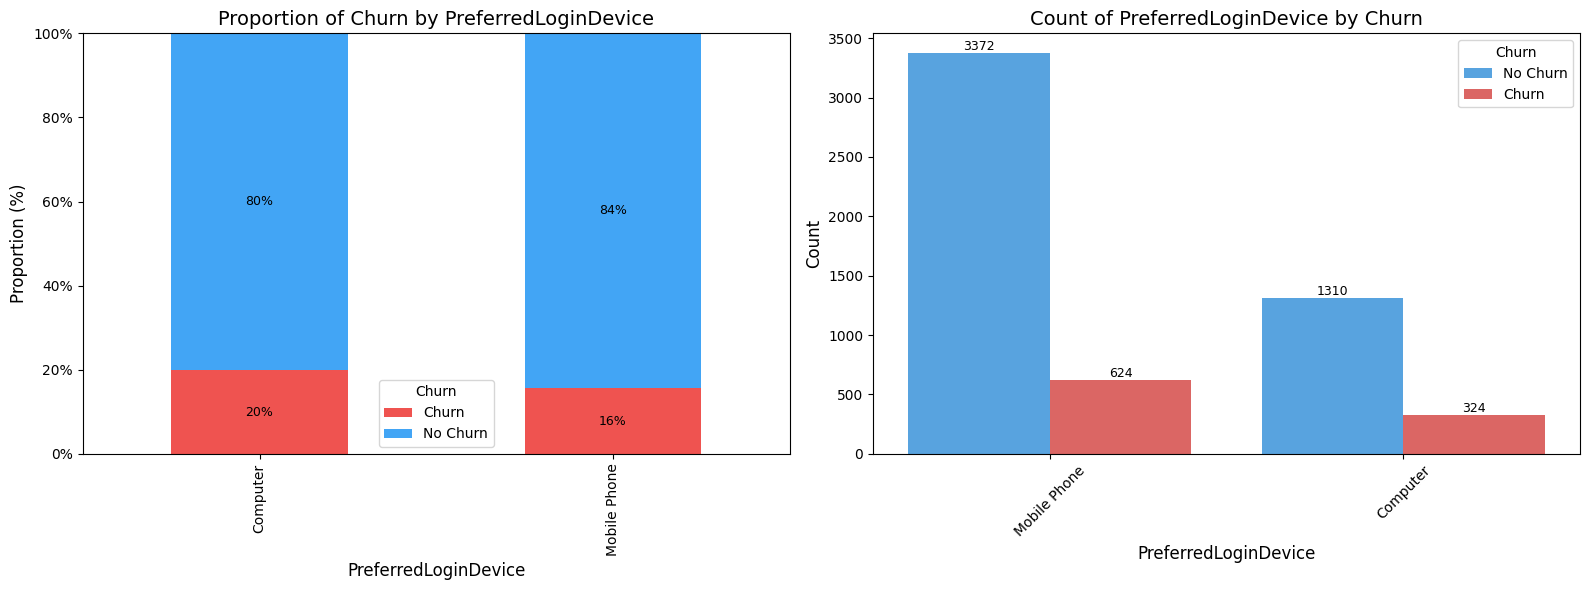

Chi-squared Test for PreferredLoginDevice: Chi2-statistic=14.401, p-value=0.000
Conclusion: There is a statistically significant association between PreferredLoginDevice and Churn.
--------------------------------------------------


In [232]:
analyze_bivariate_categorical(df_ecommerce, ['PreferredLoginDevice'])

Customers who prefer to use a "Computer" to log in have a higher churn rate (**19.8%**) than those who use a "Mobile Phone" (**15.6%**).

#### PreferredPaymentMode


Analyzing Bivariate Feature: PreferredPaymentMode vs. Churn


/tmp/ipykernel_7694/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


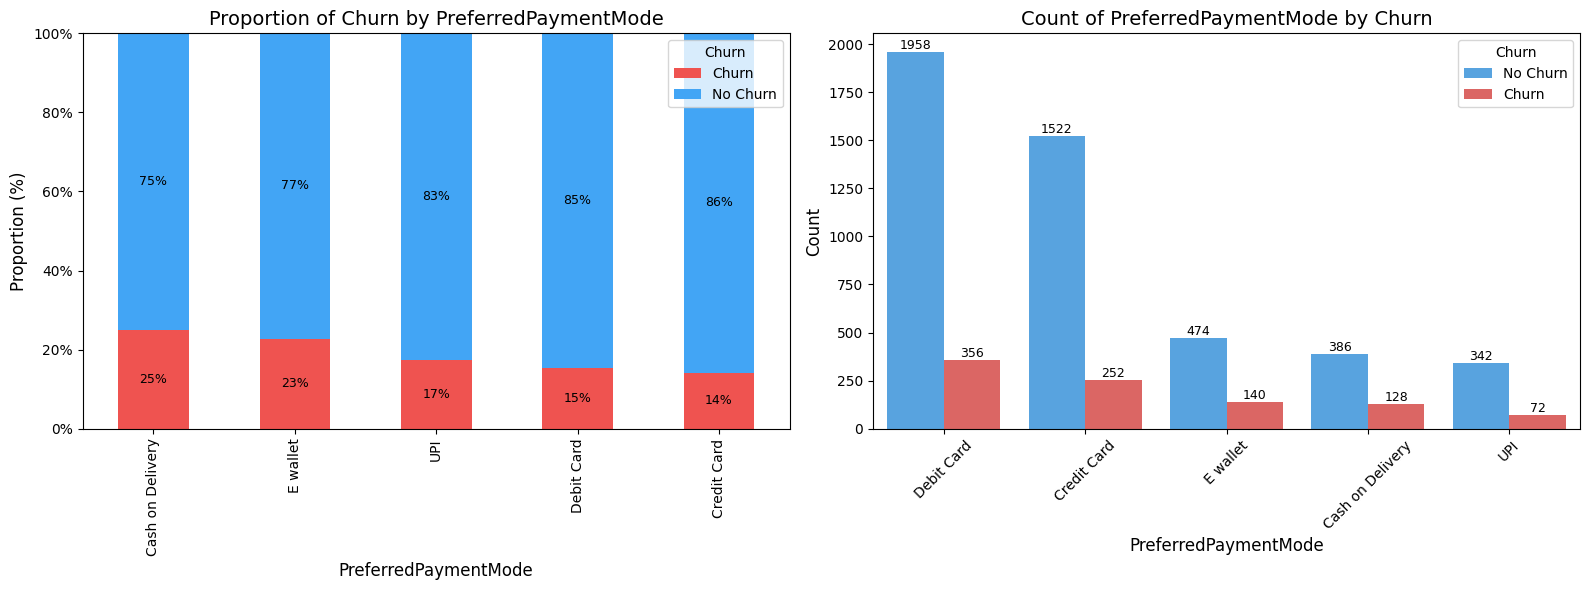

Chi-squared Test for PreferredPaymentMode: Chi2-statistic=51.829, p-value=0.000
Conclusion: There is a statistically significant association between PreferredPaymentMode and Churn.
--------------------------------------------------


In [233]:
analyze_bivariate_categorical(df_ecommerce, ['PreferredPaymentMode'])

"Cash on Delivery" has the highest churn rate at **24.9%**. This is a potential red flag, as it's the only payment method with a churn rate over 20%. Other methods like Credit Card, Debit Card, E-wallet, and UPI have lower, more consistent churn rates.

#### Gender


Analyzing Bivariate Feature: Gender vs. Churn


/tmp/ipykernel_7694/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


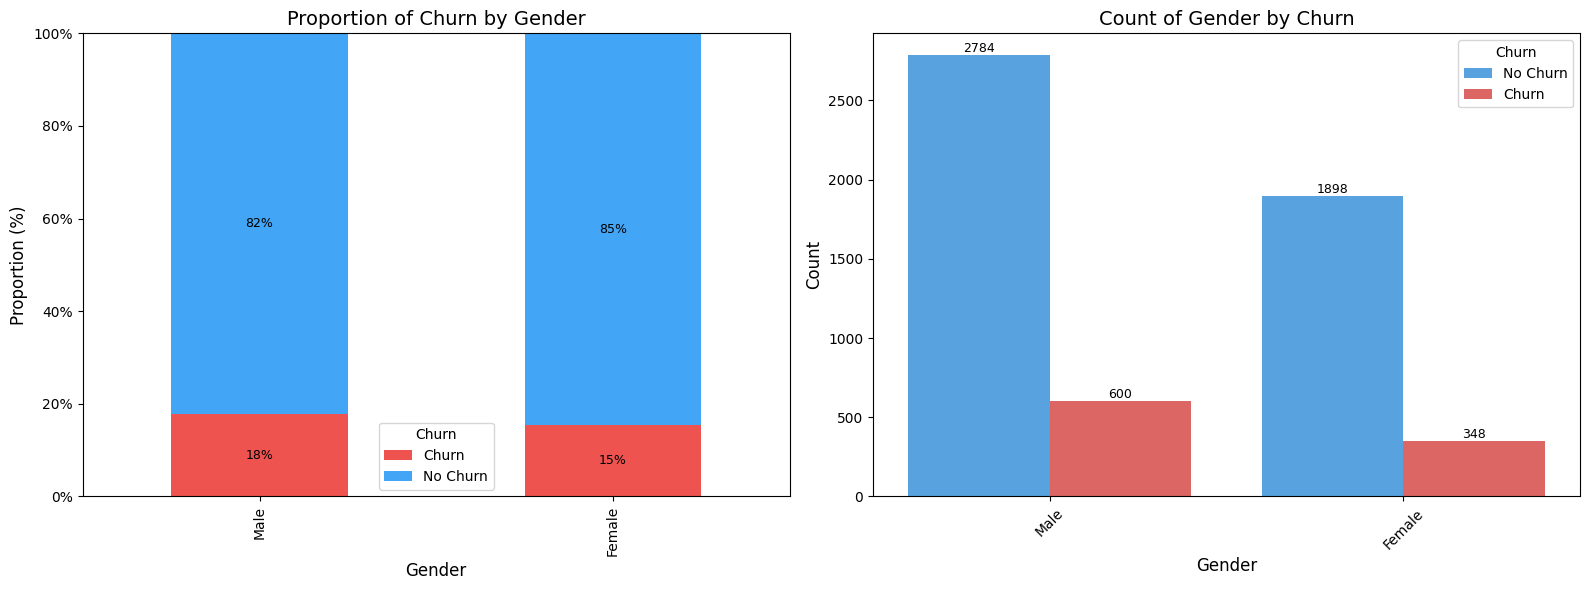

Chi-squared Test for Gender: Chi2-statistic=4.663, p-value=0.031
Conclusion: There is a statistically significant association between Gender and Churn.
--------------------------------------------------


In [234]:
analyze_bivariate_categorical(df_ecommerce, ['Gender'])

Churn rates are similar across genders, with females at **15.5%** and males at **17.7%**. This suggests that gender is not a major factor in predicting churn.

#### PreferedOrderCat


Analyzing Bivariate Feature: PreferedOrderCat vs. Churn


/tmp/ipykernel_7694/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


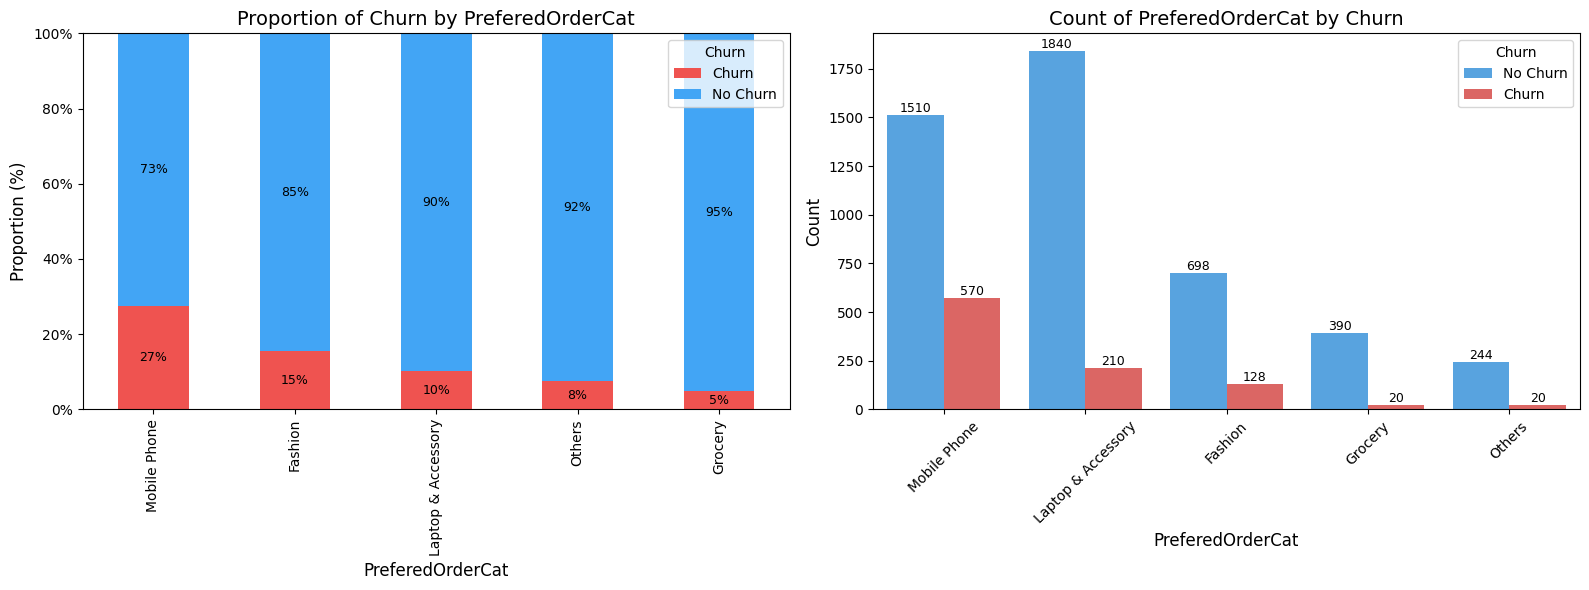

Chi-squared Test for PreferedOrderCat: Chi2-statistic=288.598, p-value=0.000
Conclusion: There is a statistically significant association between PreferedOrderCat and Churn.
--------------------------------------------------


In [235]:
analyze_bivariate_categorical(df_ecommerce, ['PreferedOrderCat'])

"Mobile Phone" orders have a very high churn rate of **27.4%**, which is significantly higher than any other category. "Grocery" orders have the lowest churn rate at **4.9%**.

#### MaritalStatus


Analyzing Bivariate Feature: MaritalStatus vs. Churn


/tmp/ipykernel_7694/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


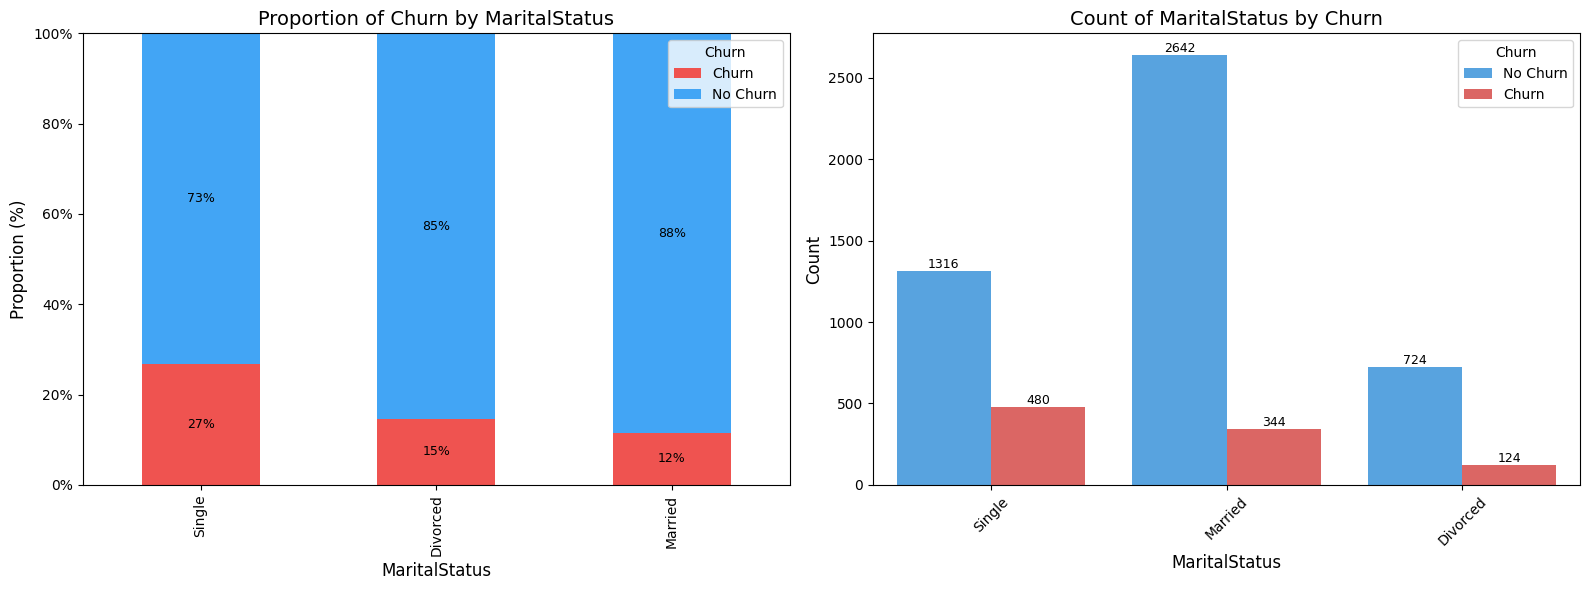

Chi-squared Test for MaritalStatus: Chi2-statistic=188.671, p-value=0.000
Conclusion: There is a statistically significant association between MaritalStatus and Churn.
--------------------------------------------------


In [236]:
analyze_bivariate_categorical(df_ecommerce, ['MaritalStatus'])

Single customers have the highest churn rate at **26.7%**, significantly higher than divorced (**14.6%**) or married (**11.5%**) customers.

#### CityTier


Analyzing Bivariate Feature: CityTier vs. Churn


/tmp/ipykernel_7694/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


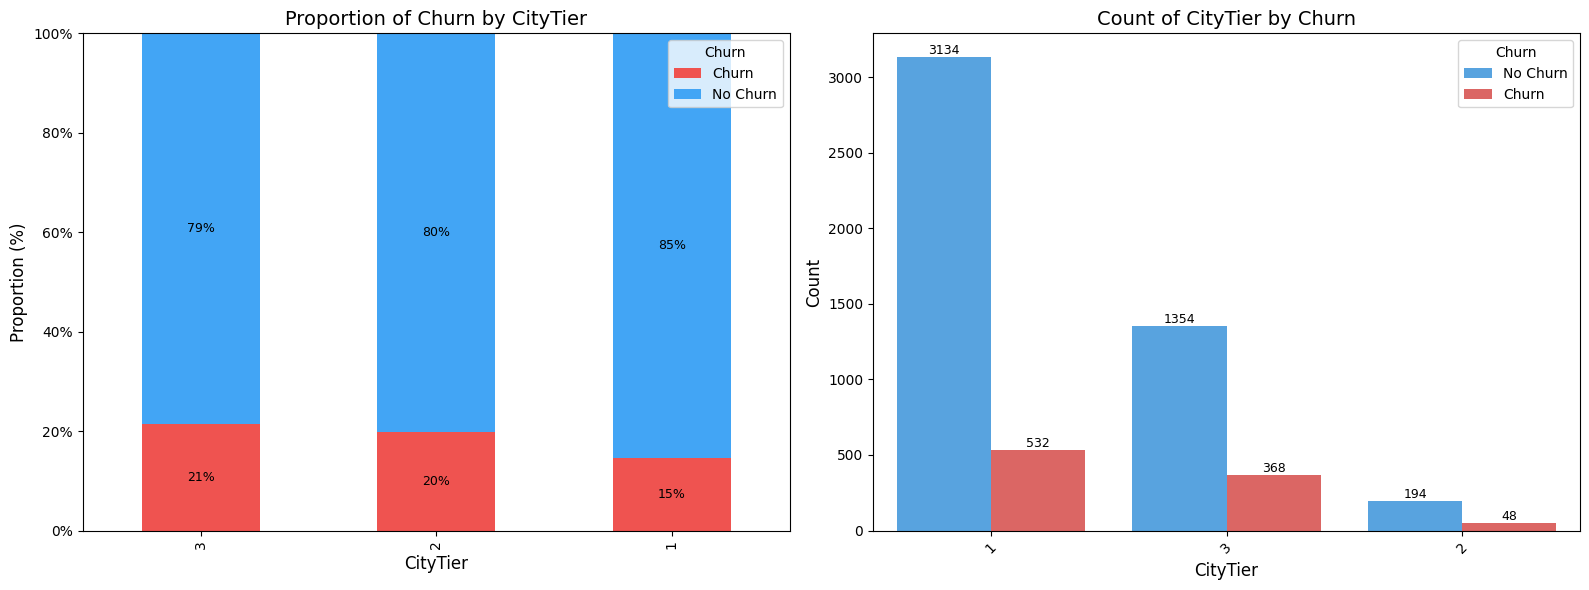

Chi-squared Test for CityTier: Chi2-statistic=40.982, p-value=0.000
Conclusion: There is a statistically significant association between CityTier and Churn.
--------------------------------------------------


In [237]:
analyze_bivariate_categorical(df_ecommerce, ['CityTier'])

Churn rates increase as the city tier number increases. Tier 1 cities have a churn rate of **14.5%**, Tier 2 at **19.8%**, and Tier 3 at **21.4%**.

#### SatisfactionScore


Analyzing Bivariate Feature: SatisfactionScore vs. Churn


/tmp/ipykernel_7694/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


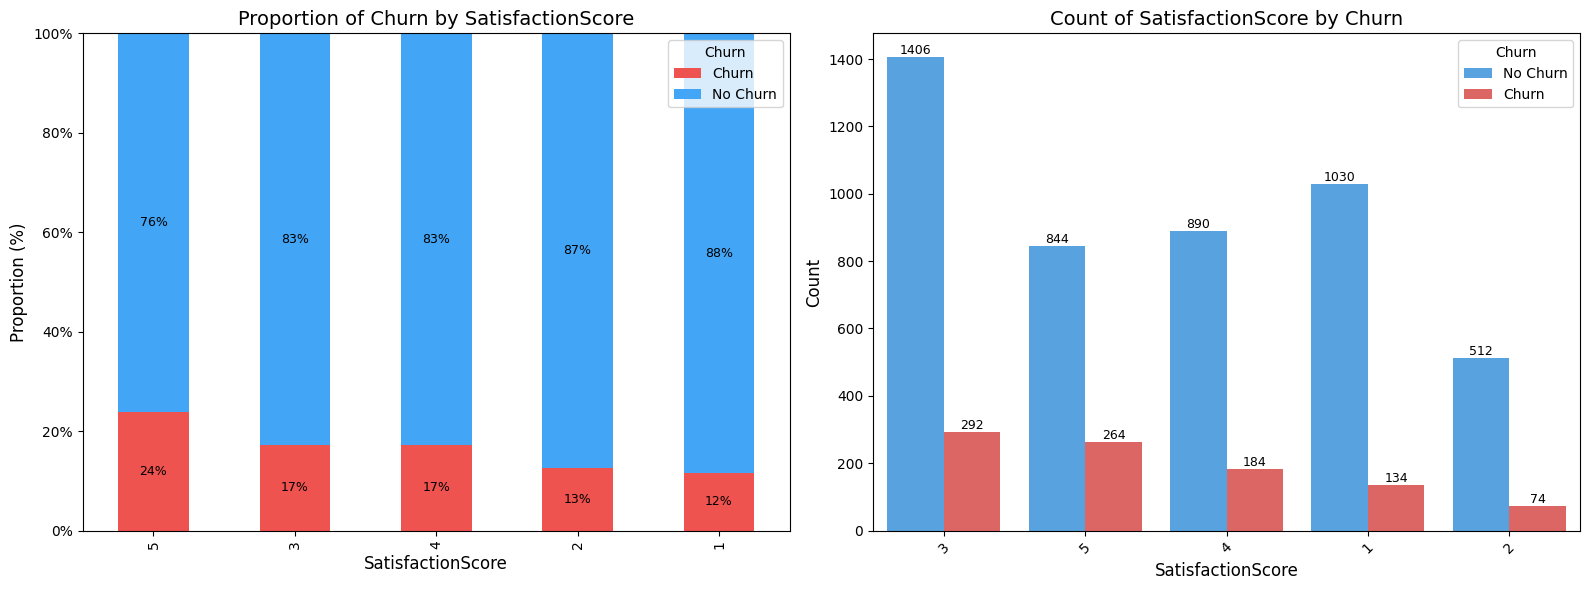

Chi-squared Test for SatisfactionScore: Chi2-statistic=69.865, p-value=0.000
Conclusion: There is a statistically significant association between SatisfactionScore and Churn.
--------------------------------------------------


In [238]:
analyze_bivariate_categorical(df_ecommerce, ['SatisfactionScore'])

There's a clear inverse relationship between satisfaction and churn. Customers with the lowest satisfaction score (1) have a churn rate of **11.5%**, while those with the highest score (5) have the highest churn rate at **23.8%**. This seemingly counterintuitive finding warrants further investigation as it is unclear the basis of scoring and may indicate that customers who are highly satisfied and then churn are doing so for reasons unrelated to satisfaction with the product/service itsel.

#### Complain


Analyzing Bivariate Feature: Complain vs. Churn


/tmp/ipykernel_7694/136081313.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{y:.0%}' for y in axes[0].get_yticks()])


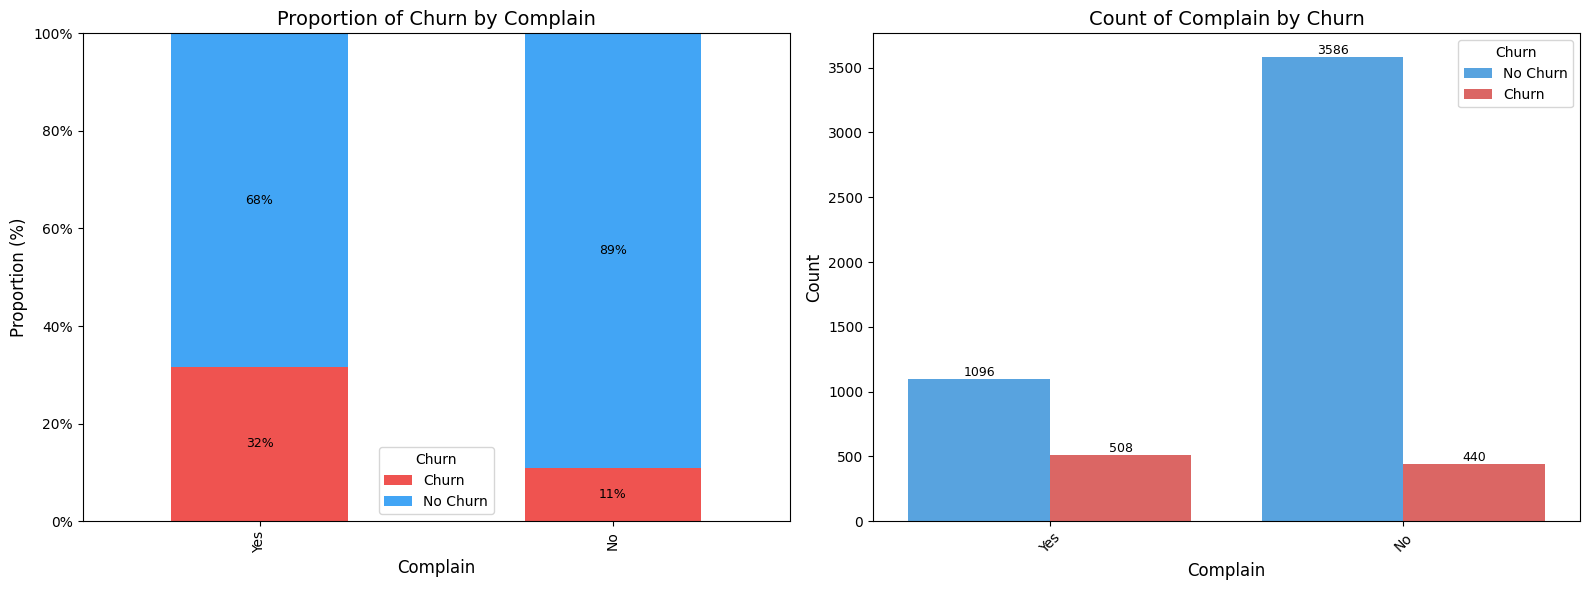

Chi-squared Test for Complain: Chi2-statistic=350.925, p-value=0.000
Conclusion: There is a statistically significant association between Complain and Churn.
--------------------------------------------------


In [239]:
analyze_bivariate_categorical(df_ecommerce, ['Complain'])

A strong correlation exists between complaints and churn. Customers who complained (**31.7%**) are much more likely to churn compared to those who didn't (**10.9%**).

## 3.7. Missing Values Analysis

--- Starting Missing Values Analysis (Focused) ---

Overall Missing values by column:
                             Total Missing  Percentage (%)
DaySinceLastOrder                      307        5.452931
OrderAmountHikeFromlastYear            265        4.706927
Tenure                                 264        4.689165
OrderCount                             258        4.582593
CouponUsed                             256        4.547069
HourSpendOnApp                         255        4.529307
WarehouseToHome                        251        4.458259

Columns with missing values are:
['DaySinceLastOrder', 'OrderAmountHikeFromlastYear', 'Tenure', 'OrderCount', 'CouponUsed', 'HourSpendOnApp', 'WarehouseToHome']


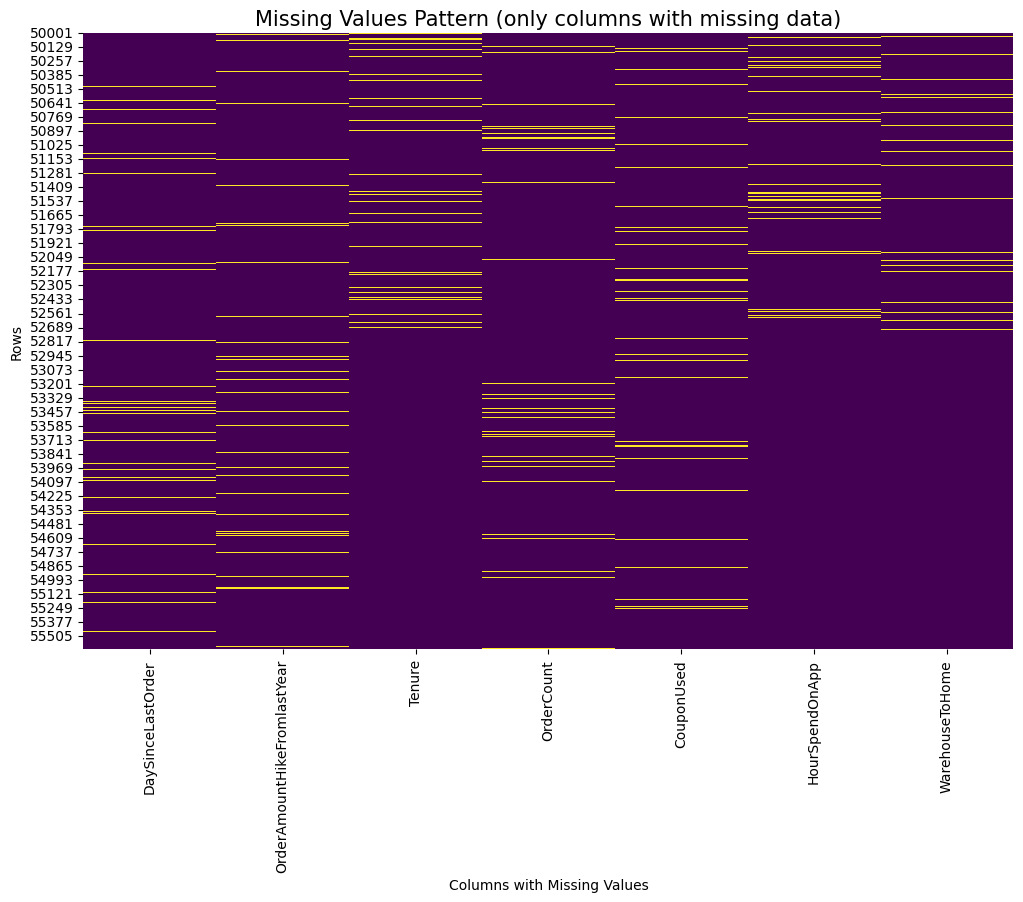

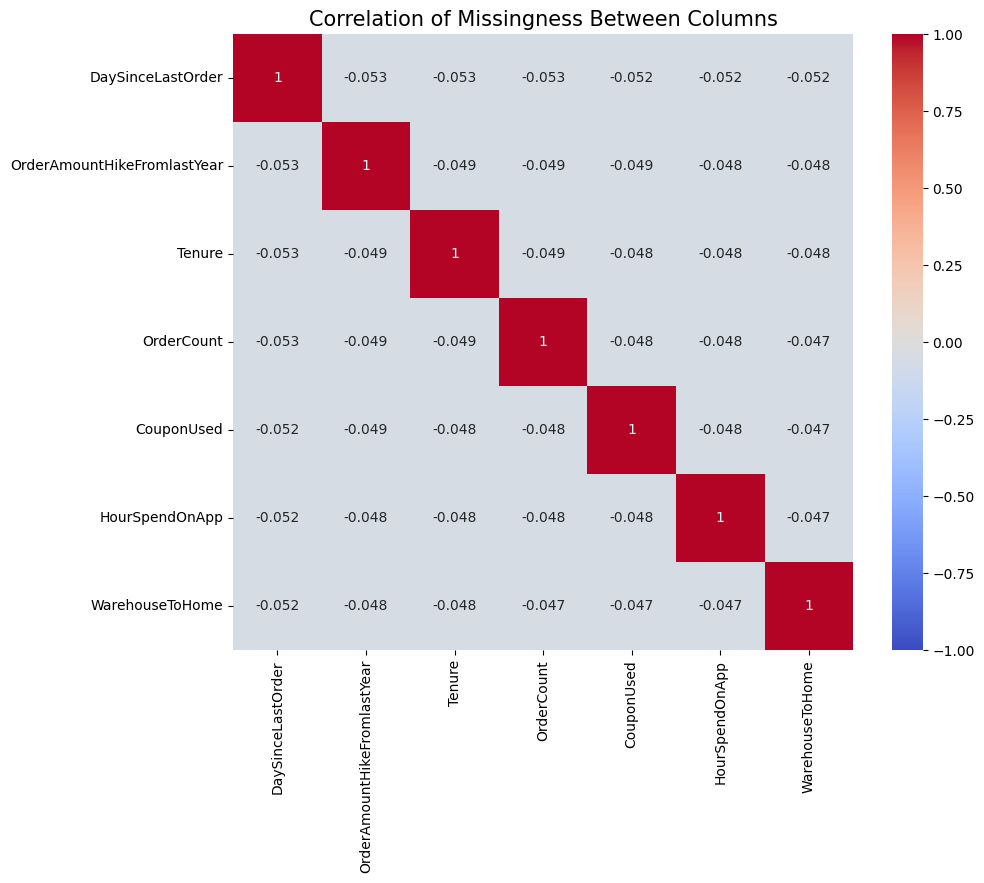

--------------------------------------------------


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting Missing Values Analysis (Focused) ---")

# Overall Missing Values
missing_data = df_ecommerce.isnull().sum()
total_rows = len(df_ecommerce)

missing_df = pd.DataFrame({
    'Total Missing': missing_data,
    'Percentage (%)': (missing_data / total_rows) * 100
}).sort_values(by='Percentage (%)', ascending=False)

columns_with_missing_data = missing_df[missing_df['Total Missing'] > 0]

print("\nOverall Missing values by column:")
print(columns_with_missing_data)

if not columns_with_missing_data.empty:
    print("\nColumns with missing values are:")
    print(columns_with_missing_data.index.tolist())
else:
    print("\nNo missing values found in the dataset.")

# --- 1. Heatmap of missing values (only for columns with missing data) ---
if not columns_with_missing_data.empty:
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        df_ecommerce[columns_with_missing_data.index].isnull(),
        cbar=False, cmap="viridis"
    )
    plt.title("Missing Values Pattern (only columns with missing data)", fontsize=15)
    plt.xlabel("Columns with Missing Values")
    plt.ylabel("Rows")
    plt.show()

# --- 2. Correlation of missingness ---
if len(columns_with_missing_data) > 1:
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df_ecommerce[columns_with_missing_data.index].isnull().corr(),
        annot=True, cmap="coolwarm", vmin=-1, vmax=1
    )
    plt.title("Correlation of Missingness Between Columns", fontsize=15)
    plt.show()

print("-" * 50)

Seems no correlation between missing values features

## 3.8. Multicollinearity and Correlation

--- Correlation Analysis (Spearman Method) ---


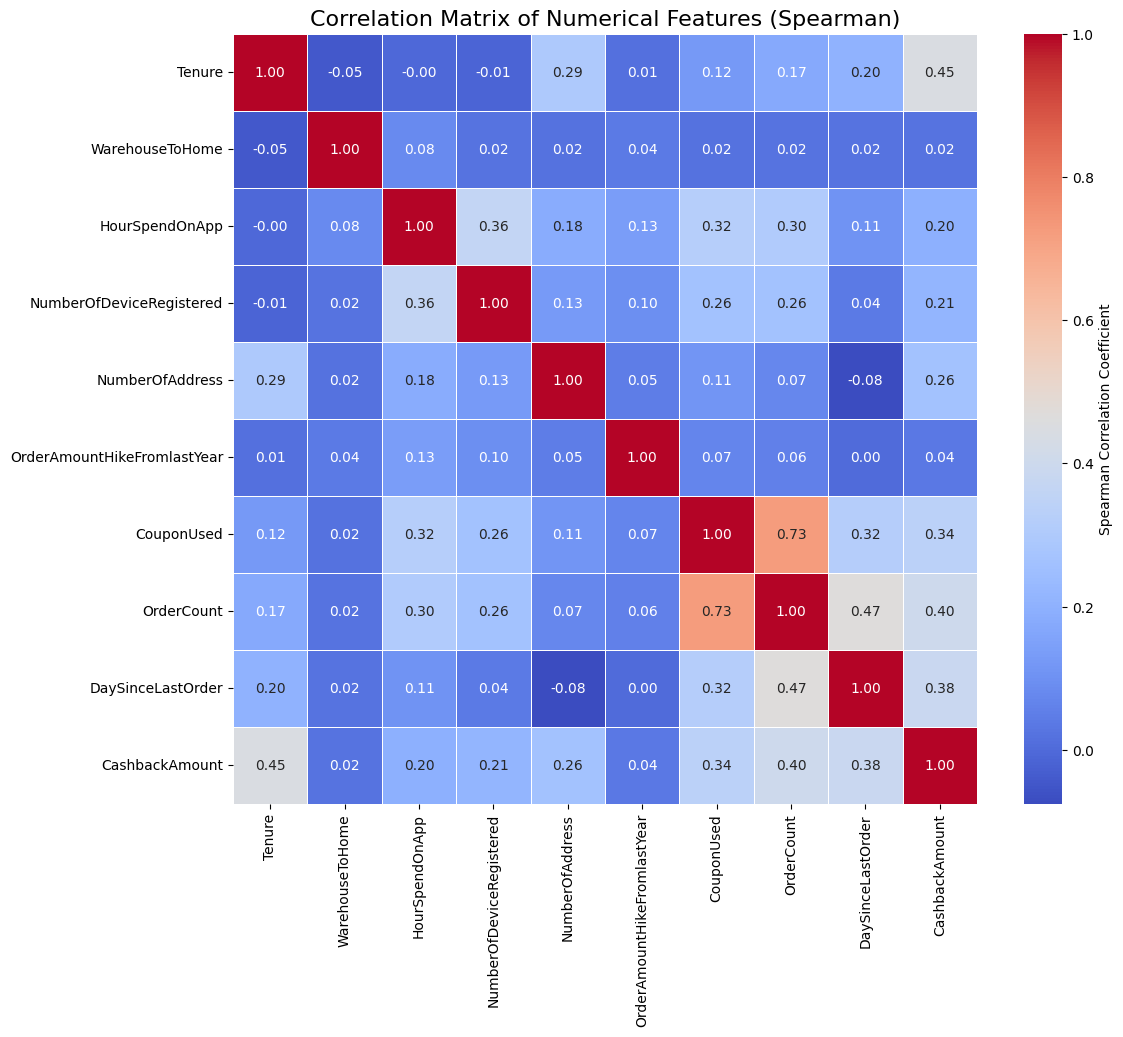

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# We will use only the numerical features for this analysis
numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

# --- Correlation Matrix and Heatmap ---
print("--- Correlation Analysis (Spearman Method) ---")

# Calculate the correlation matrix using the Spearman method
corr_matrix = df_ecommerce[numerical_features].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, cbar_kws={'label': 'Spearman Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features (Spearman)', fontsize=16)
plt.show()

### Analysis of Numerical Features and Multicollinearity

Based on the provided correlation matrix, here are the key insights.

-----

### Feature Correlations (Spearman)

The correlation matrix shows the relationships between pairs of numerical features.

  * **Moderate Positive Correlations**:
      * **OrderCount and CouponUsed (0.73)**: Customers who place more orders tend to use more coupons.
      * **DaysSinceLastOrder and OrderCount (0.47)**: This is an interesting inverse relationship. The correlation is moderate, but it suggests that as the number of orders increases, the days since the last order might also increase, or vice-versa.
      * **Tenure and CashbackAmount (0.45)**: Customers who have been with the company longer tend to receive more cashback.
  * **Weak Correlations**: Most other feature pairs show very weak correlations (values close to 0), indicating they have minimal linear relationship with each other. For example, **HoursSpendOnApp** has a very low correlation with all other features.

## 3.9. Save Dataset

In [ ]:
# df_ecommerce.to_csv('eda.csv')

# 4. Preprocessing

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
import joblib

# --- Global variable for reproducibility ---
RANDOM_STATE = 42

# --- 1. Load the dataset ---
try:
    df = pd.read_csv('eda.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'eda.csv' not found. Please check the file path.")
    exit()

# --- 2. Define features and target ---
TARGET = 'Churn'

# Categorization based on the provided feedback
# CustomerID is not used as features
df.set_index('CustomerID', inplace=True)

ordinal_features = ['CityTier', 'SatisfactionScore']
numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
categorical_features = ['PreferedOrderCat', 'MaritalStatus', 'PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'Complain']

# Separate target variable
X = df.drop(columns=[TARGET])
y = df[TARGET]

# --- 3. Split the data to prevent data leakage ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f"Original data shape: {X.shape}")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"\nOriginal Churn distribution: {Counter(y)}")
print(f"Training Churn distribution: {Counter(y_train)}")

# --- 4. Define Preprocessing Pipelines ---
# A. Numerical Preprocessor
numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# B. Nominal Categorical Preprocessor (One-Hot Encoding)
nominal_preprocessor = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# C. Ordinal Categorical Preprocessor (Ordinal Encoding)
ordinal_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

# D. Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_features),
        ('nominal_cat', nominal_preprocessor, categorical_features),
        ('ordinal_cat', ordinal_preprocessor, ordinal_features)
    ],
    remainder='passthrough'
)

# --- 5. Build Full Pipelines ---
# Pipeline with RandomOverSampler
ros_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=RANDOM_STATE))
])

# Pipeline with SMOTE
smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE))
])

# --- 6. Save Pipelines ---
joblib.dump(ros_pipeline, 'pipeline_ros.pkl')
joblib.dump(smote_pipeline, 'pipeline_smote.pkl')

print("\n✅ Pipelines saved:")
print("- ROS pipeline: pipeline_ros.pkl")
print("- SMOTE pipeline: pipeline_smote.pkl")

Dataset loaded successfully.
Original data shape: (5630, 18)
Training data shape: (4504, 18)
Testing data shape: (1126, 18)

Original Churn distribution: Counter({0: 4682, 1: 948})
Training Churn distribution: Counter({0: 3746, 1: 758})

✅ Pipelines saved:
- ROS pipeline: pipeline_ros.pkl
- SMOTE pipeline: pipeline_smote.pkl


In [21]:
# If X_test is still a DataFrame after preprocessing
test_df = X_test.copy()
test_df['Churn'] = y_test.values

# If X_test is a NumPy array after preprocessing
# you’ll need to bring back the feature names
if not isinstance(X_test, pd.DataFrame):
    feature_names = preprocessor.get_feature_names_out()
    test_df = pd.DataFrame(X_test, columns=feature_names)
    test_df['Churn'] = y_test.values

# Save to CSV for inspection or later use
test_df.to_csv("test_set.csv")

print("Test set saved successfully with shape:", test_df.shape)

Test set saved successfully with shape: (1126, 19)


# 5. Methodology (Modeling/Analysis)

## 5.1. Benchmark Model

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:56:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- ROS Results Summary ---
                 Model  F2-Score  ROC-AUC  Precision   Recall
RandomForestClassifier  0.967403 0.998650   0.963351 0.968421
         XGBClassifier  0.964173 0.999022   0.968254 0.963158
DecisionTreeClassifier  0.876727 0.925664   0.911602 0.868421
  KNeighborsClassifier  0.864374 0.969408   0.630662 0.952632
    LogisticRegression  0.723801 0.884233   0.445355 0.857895


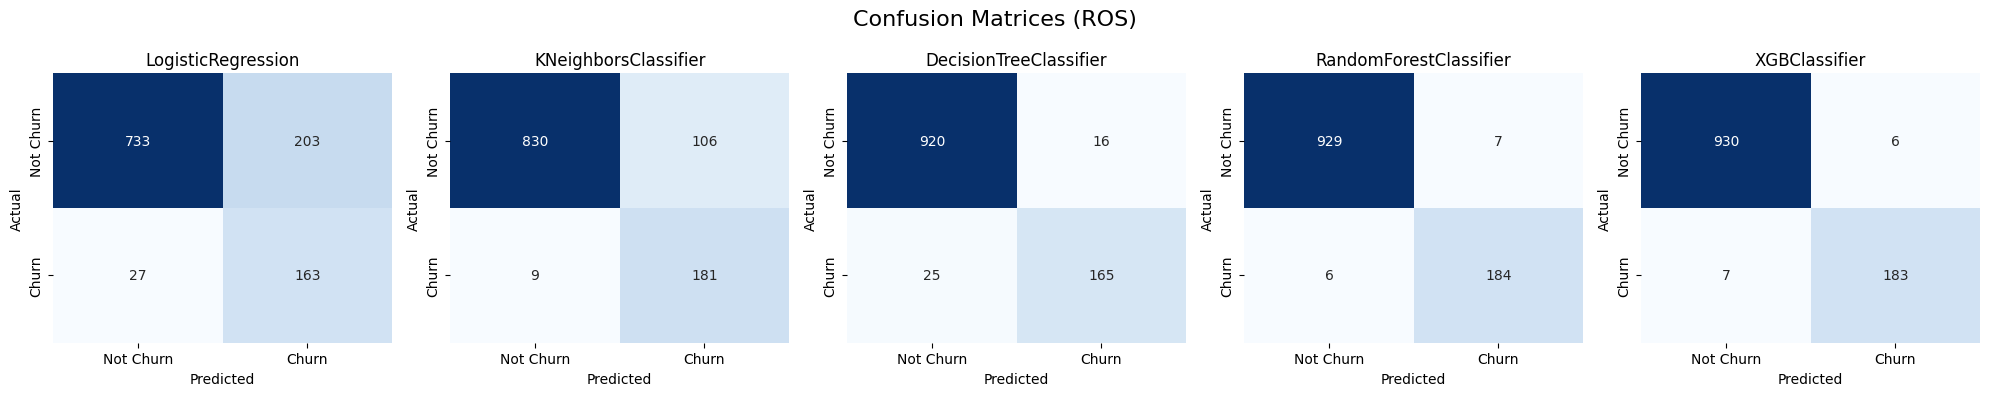

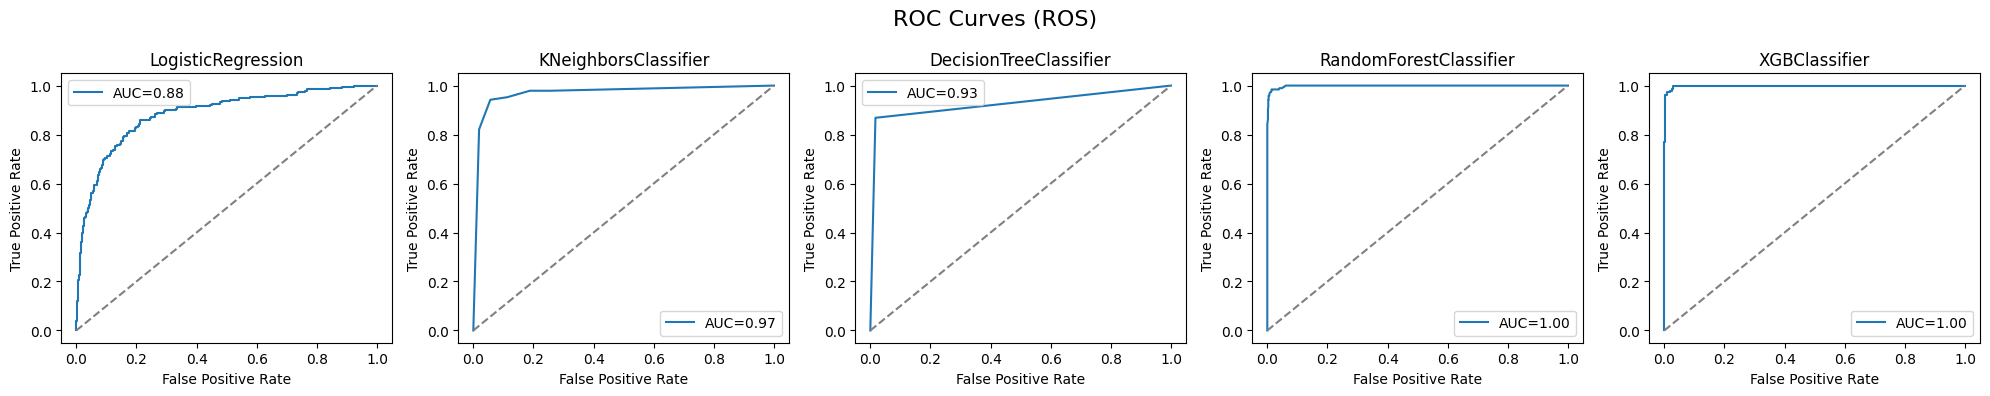

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:56:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- SMOTE Results Summary ---
                 Model  F2-Score  ROC-AUC  Precision   Recall
         XGBClassifier  0.958904 0.997627   0.962963 0.957895
DecisionTreeClassifier  0.916581 0.950793   0.843602 0.936842
RandomForestClassifier  0.892667 0.995133   0.928177 0.884211
  KNeighborsClassifier  0.856742 0.968466   0.594156 0.963158
    LogisticRegression  0.705301 0.882720   0.444759 0.826316


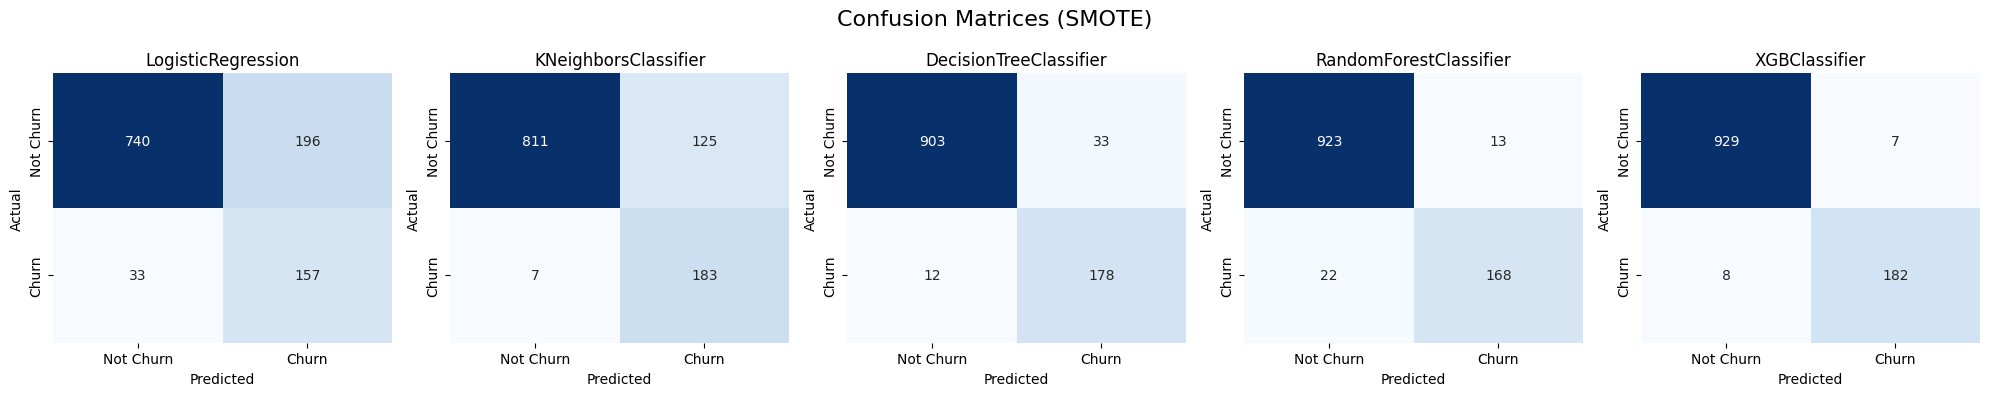

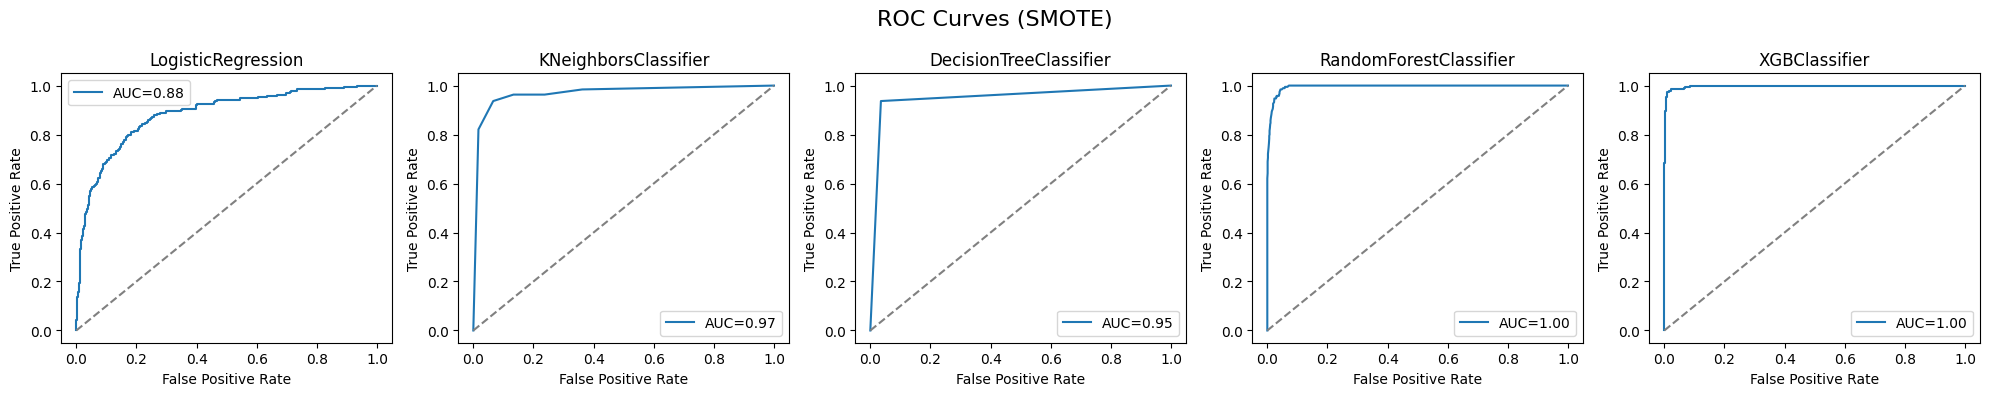

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    fbeta_score, roc_auc_score, precision_score, recall_score,
    confusion_matrix, roc_curve, auc
)

from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

# --- Candidate Models ---
simple_models = {
    'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForestClassifier': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBClassifier': XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
}

# --- Pipelines to compare ---
pipelines = {
    "ROS": joblib.load("pipeline_ros.pkl"),
    "SMOTE": joblib.load("pipeline_smote.pkl")
}

# --- Benchmark Function ---
def benchmark_pipeline(pipeline_name, pipeline, models, X_train, y_train, X_test, y_test):
    results = []
    conf_matrices = {}
    roc_curves = {}

    for name, model in models.items():
        # Fit pipeline + model
        full_pipeline = ImbPipeline(steps=pipeline.steps + [('model', model)])
        full_pipeline.fit(X_train, y_train)

        # Predictions
        y_pred = full_pipeline.predict(X_test)
        y_pred_proba = (
            full_pipeline.predict_proba(X_test)[:, 1]
            if hasattr(full_pipeline, 'predict_proba') else None
        )

        # Metrics
        f2 = fbeta_score(y_test, y_pred, beta=2)
        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        conf_matrix = confusion_matrix(y_test, y_pred)

        results.append({
            'Model': name,
            'F2-Score': f2,
            'ROC-AUC': roc_auc,
            'Precision': precision,
            'Recall': recall
        })

        # Save confusion matrix
        conf_matrices[name] = conf_matrix

        # Save ROC curve
        if y_pred_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_curves[name] = (fpr, tpr, auc(fpr, tpr))

    # Results DataFrame
    results_df = pd.DataFrame(results).sort_values(by="F2-Score", ascending=False)
    print(f"\n--- {pipeline_name} Results Summary ---")
    print(results_df.to_string(index=False))

    # --- Confusion Matrices Subplots ---
    fig, axes = plt.subplots(1, len(models), figsize=(20, 4))
    for ax, (name, matrix) in zip(axes, conf_matrices.items()):
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=["Not Churn", "Churn"],
                    yticklabels=["Not Churn", "Churn"], ax=ax)
        ax.set_title(f"{name}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
    plt.suptitle(f"Confusion Matrices ({pipeline_name})", fontsize=16)
    plt.tight_layout()
    plt.show()

    # --- ROC Curves Subplots ---
    fig, axes = plt.subplots(1, len(roc_curves), figsize=(20, 4))
    for ax, (name, (fpr, tpr, roc_auc)) in zip(axes, roc_curves.items()):
        ax.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
        ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
        ax.set_title(name)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend()
    plt.suptitle(f"ROC Curves ({pipeline_name})", fontsize=16)
    plt.tight_layout()
    plt.show()

    return results_df


# --- Run Benchmark for Both Pipelines ---
ros_results = benchmark_pipeline("ROS", pipelines["ROS"], simple_models, X_train, y_train, X_test, y_test)
smote_results = benchmark_pipeline("SMOTE", pipelines["SMOTE"], simple_models, X_train, y_train, X_test, y_test)

## 5.2. Hyperparameter Tuning


--- Running RF+ROS ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params for RF+ROS: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__n_estimators': 50}
Best CV F2-Score: 0.8518

--- Running RF+SMOTE ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params for RF+SMOTE: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}
Best CV F2-Score: 0.7999

--- Running XGB+ROS ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:15:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:15:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:15:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:15:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

Best params for XGB+ROS: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 50}
Best CV F2-Score: 0.8744

--- Running XGB+SMOTE ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:15:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:15:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:15:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:15:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

Best params for XGB+SMOTE: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 200}
Best CV F2-Score: 0.8364

--- Final Results ---
Experiment  F2-Score  Precision   Recall  ROC-AUC
   XGB+ROS  0.971933   0.925743 0.984211 0.997824
 XGB+SMOTE  0.960929   0.973262 0.957895 0.998459
    RF+ROS  0.952626   0.876777 0.973684 0.997245
  RF+SMOTE  0.892667   0.928177 0.884211 0.995133

Best experiment: XGB+ROS with F2-Score 0.9719


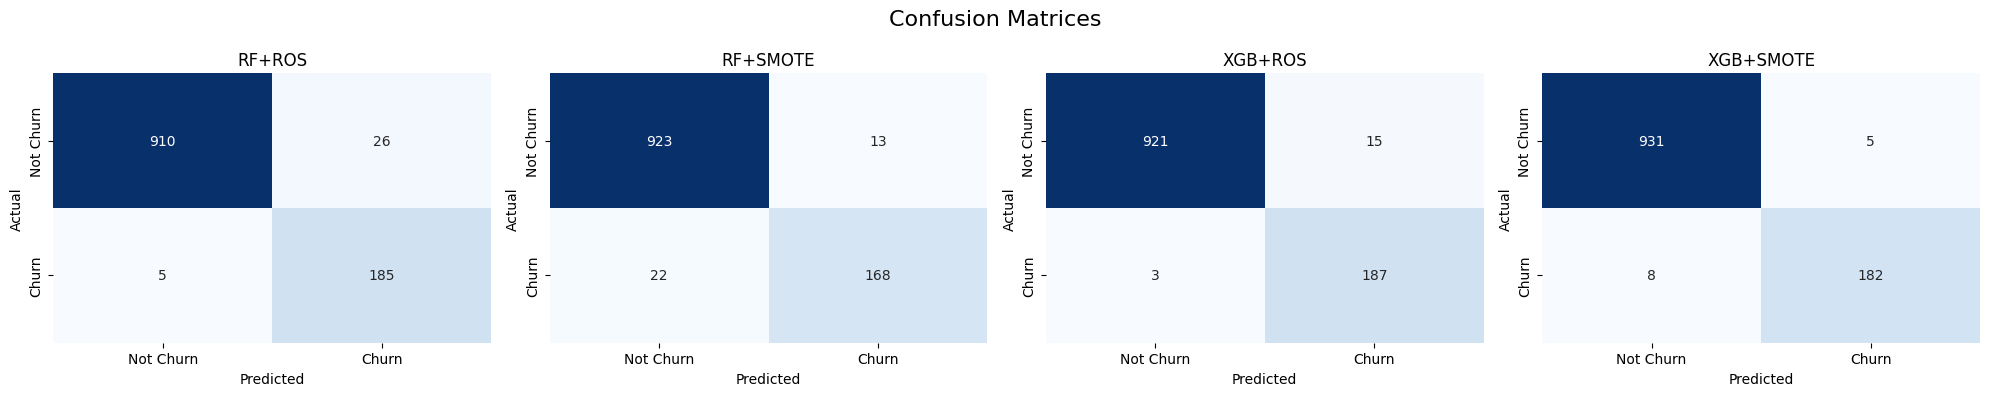

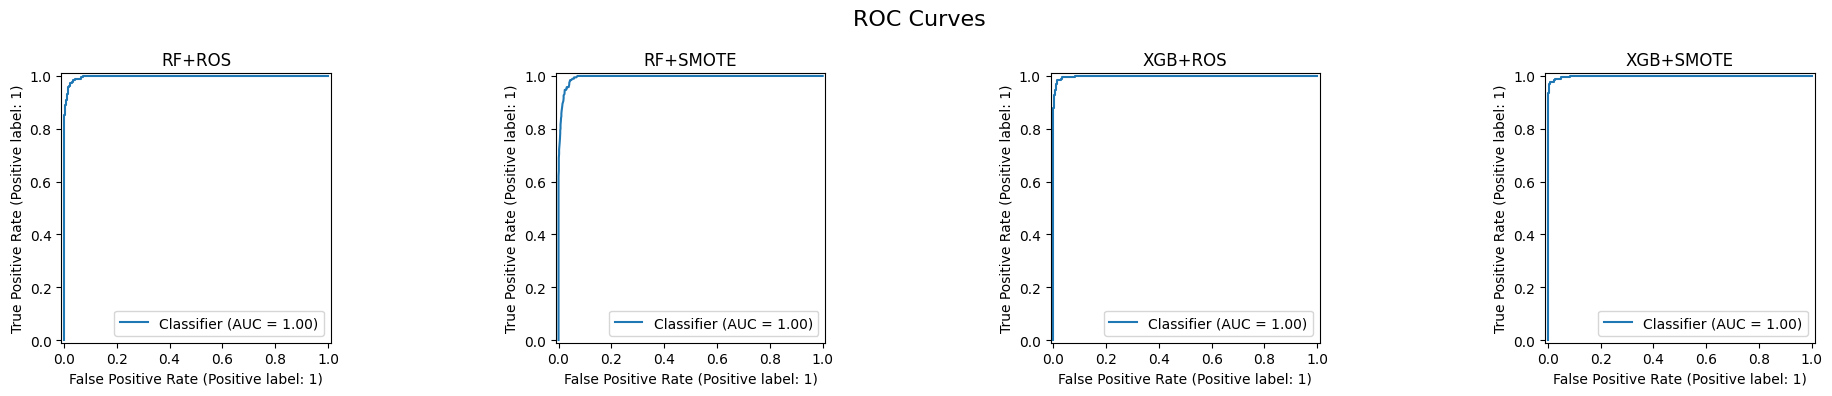

Best model pipeline saved as best_model_pipeline.pkl


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    fbeta_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, make_scorer, RocCurveDisplay
)
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# --- Hyperparameter Grids ---
rf_params = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [5, 10, None],
    "model__min_samples_leaf": [1, 2, 4],
}

xgb_params = {
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__max_depth": [3, 5, 7],
}

# --- Experiments Setup ---
experiments = {
    "RF+ROS": {
        "pipeline": ImbPipeline(steps=ros_pipeline.steps + [
            ("model", RandomForestClassifier(random_state=RANDOM_STATE))
        ]),
        "params": rf_params
    },
    "RF+SMOTE": {
        "pipeline": ImbPipeline(steps=smote_pipeline.steps + [
            ("model", RandomForestClassifier(random_state=RANDOM_STATE))
        ]),
        "params": rf_params
    },
    "XGB+ROS": {
        "pipeline": ImbPipeline(steps=ros_pipeline.steps + [
            ("model", XGBClassifier(
                random_state=RANDOM_STATE,
                use_label_encoder=False,
                eval_metric="logloss"
            ))
        ]),
        "params": xgb_params
    },
    "XGB+SMOTE": {
        "pipeline": ImbPipeline(steps=smote_pipeline.steps + [
            ("model", XGBClassifier(
                random_state=RANDOM_STATE,
                use_label_encoder=False,
                eval_metric="logloss"
            ))
        ]),
        "params": xgb_params
    }
}

# --- Custom Scorers ---
f2_scorer = make_scorer(fbeta_score, beta=2)
scoring_metrics = {
    "F2-Score": f2_scorer,
    "Precision": make_scorer(precision_score),
    "Recall": make_scorer(recall_score),
    "ROC-AUC": make_scorer(roc_auc_score)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# --- Run Experiments ---
results = []
conf_matrices = {}
roc_curves = {}
best_model = None
best_score = 0
best_name = None

for name, exp in experiments.items():
    print(f"\n--- Running {name} ---")
    
    grid = GridSearchCV(
        estimator=exp["pipeline"],
        param_grid=exp["params"],
        scoring=f2_scorer,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)  # uses pipeline (preprocessing + resampling + model)
    
    best_estimator = grid.best_estimator_
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best CV F2-Score: {grid.best_score_:.4f}")
    
    # --- Predictions ---
    y_pred = best_estimator.predict(X_test)
    y_pred_proba = (
        best_estimator.predict_proba(X_test)[:, 1]
        if hasattr(best_estimator, "predict_proba") else None
    )
    
    f2 = fbeta_score(y_test, y_pred, beta=2)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    cm = confusion_matrix(y_test, y_pred)
    
    results.append({
        "Experiment": name,
        "F2-Score": f2,
        "Precision": precision,
        "Recall": recall,
        "ROC-AUC": roc_auc
    })
    
    # store plots data
    conf_matrices[name] = cm
    if y_pred_proba is not None:
        roc_curves[name] = (y_test, y_pred_proba)
    
    # Track best
    if f2 > best_score:
        best_score = f2
        best_model = best_estimator
        best_name = name

# --- Results Summary ---
results_df = pd.DataFrame(results).sort_values(by="F2-Score", ascending=False)
print("\n--- Final Results ---")
print(results_df.to_string(index=False))
print(f"\nBest experiment: {best_name} with F2-Score {best_score:.4f}")

# --- Plot Confusion Matrices ---
fig, axes = plt.subplots(1, len(conf_matrices), figsize=(5 * len(conf_matrices), 4))
if len(conf_matrices) == 1:
    axes = [axes]
for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                xticklabels=["Not Churn", "Churn"],
                yticklabels=["Not Churn", "Churn"])
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
fig.suptitle("Confusion Matrices", fontsize=16)
plt.tight_layout()
plt.show()

# --- Plot ROC Curves ---
fig, axes = plt.subplots(1, len(roc_curves), figsize=(5 * len(roc_curves), 4))
if len(roc_curves) == 1:
    axes = [axes]
for ax, (name, (y_true, y_proba)) in zip(axes, roc_curves.items()):
    RocCurveDisplay.from_predictions(y_true, y_proba, ax=ax)
    ax.set_title(name)
fig.suptitle("ROC Curves", fontsize=16)
plt.tight_layout()
plt.show()

# --- Save Best Model Pipeline ---
joblib.dump(best_model, "best_model_pipeline.pkl")
print(f"Best model pipeline saved as best_model_pipeline.pkl")

## 5.3. Feature Importances

/tmp/ipykernel_7694/394814515.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="viridis")


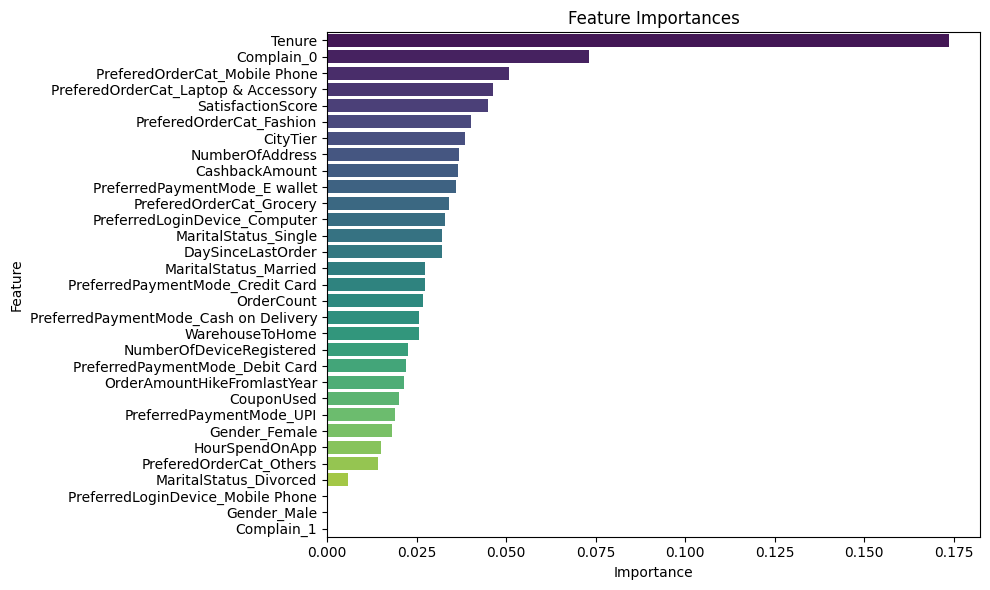

In [68]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the best model pipeline ---
best_pipeline = joblib.load("best_model_pipeline.pkl")

# --- Get feature names from the preprocessing part of the pipeline ---
# Assuming your pipeline has a 'preprocessor' step (ColumnTransformer) inside
preprocessor = None
for name, step in best_pipeline.named_steps.items():
    if hasattr(step, "transformers_"):  # ColumnTransformer
        preprocessor = step
        break

if preprocessor is None:
    raise ValueError("Could not find a ColumnTransformer (preprocessor) in the pipeline.")

# Extract feature names after preprocessing
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if hasattr(trans, "get_feature_names_out"):
        feature_names.extend(trans.get_feature_names_out(cols))
    else:
        feature_names.extend(cols)

# --- Get model from pipeline ---
model = best_pipeline.named_steps["model"]

# --- Get feature importances ---
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
else:
    raise ValueError("The model does not support feature importances.")

# --- Create DataFrame ---
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

## 5.4. Feature Selection

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:50:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:50:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:50:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:50:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

Original number of features: 31
Optimal number of features selected by RFECV: 27

--- Comparison Results ---
                 Pipeline  F2-Score  Precision   Recall  ROC-AUC
            Full Features  0.971933   0.925743 0.984211 0.997824
Feature Selection (RFECV)  0.964730   0.911765 0.978947 0.998617


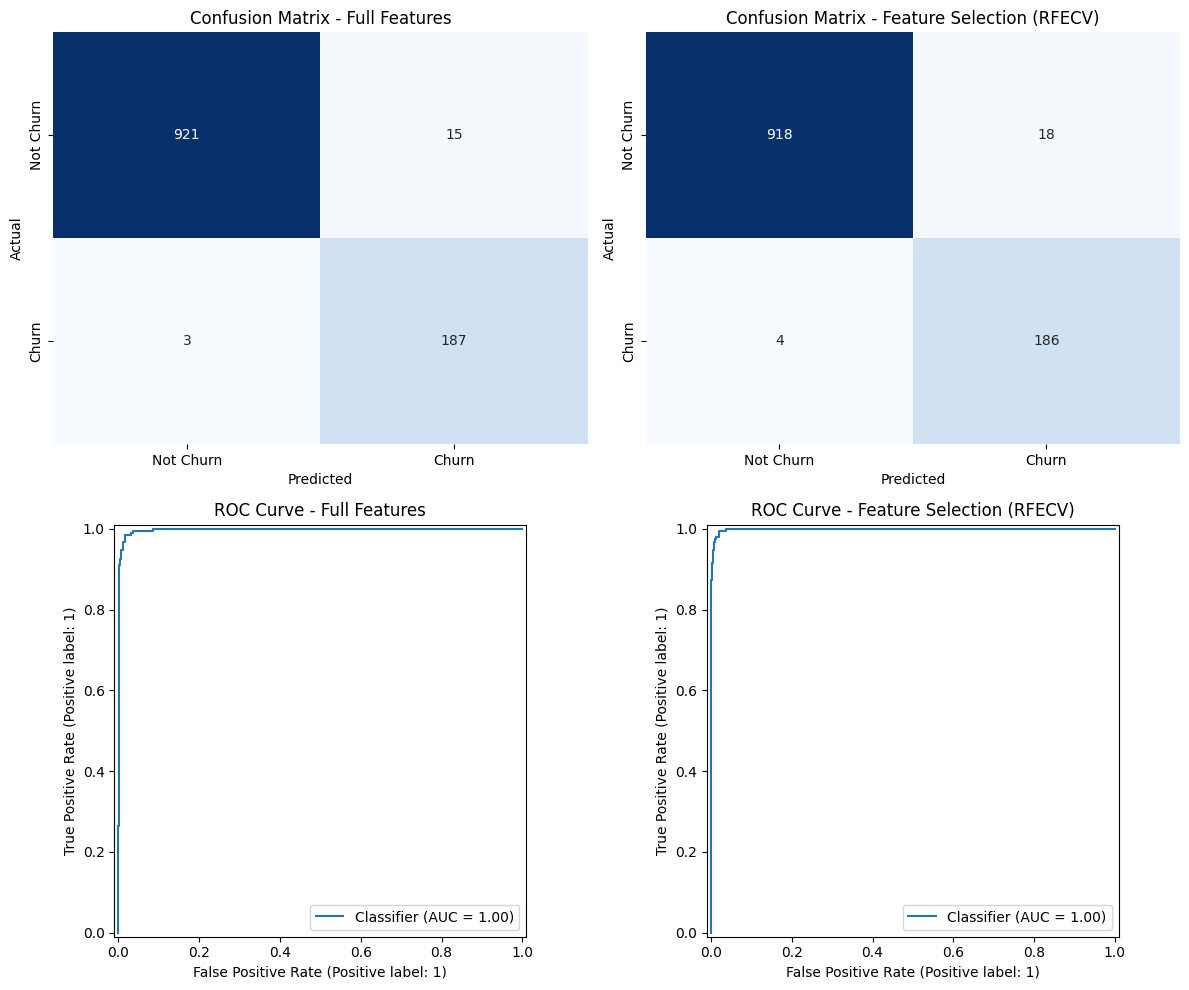

Saved RFECV pipeline as best_selection_model_pipeline.pkl


In [66]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.feature_selection import RFECV
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import (
    fbeta_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, make_scorer
)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# --- Load Best Pipeline ---
best_pipeline = joblib.load("best_model_pipeline.pkl")

# Extract steps safely
preprocessor = best_pipeline.named_steps["preprocessor"]
sampler = best_pipeline.named_steps["ros"] if "ros" in best_pipeline.named_steps else best_pipeline.named_steps["smote"]
trained_model = best_pipeline.named_steps["model"]

# Clone model to avoid overwriting trained one
model = clone(trained_model)

# --- RFECV with F2-Score ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring=make_scorer(fbeta_score, beta=2),
    n_jobs=-1
)

# New pipeline with RFECV
pipeline_rfecv = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    (sampler.__class__.__name__.lower(), sampler),
    ("feature_selection", rfecv),
    ("model", model)
])

# --- Fit on training data ---
pipeline_rfecv.fit(X_train, y_train)

print("Original number of features:", len(preprocessor.get_feature_names_out()))
print("Optimal number of features selected by RFECV:", rfecv.n_features_)

# --- Evaluation Helper ---
def evaluate_pipeline(pipeline, X_test, y_test, label):
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None

    f2 = fbeta_score(y_test, y_pred, beta=2)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    cm = confusion_matrix(y_test, y_pred)

    return {
        "Pipeline": label,
        "F2-Score": f2,
        "Precision": precision,
        "Recall": recall,
        "ROC-AUC": roc_auc,
        "ConfusionMatrix": cm,
        "Probas": y_proba
    }

# --- Compare Both Pipelines ---
results = []
results.append(evaluate_pipeline(best_pipeline, X_test, y_test, "Full Features"))
results.append(evaluate_pipeline(pipeline_rfecv, X_test, y_test, "Feature Selection (RFECV)"))

results_df = pd.DataFrame(results).drop(columns=["ConfusionMatrix", "Probas"])
print("\n--- Comparison Results ---")
print(results_df.to_string(index=False))

# --- Visualization (Side-by-Side) ---
fig, axes = plt.subplots(2, len(results), figsize=(6*len(results), 10))

for idx, res in enumerate(results):
    # Confusion Matrix
    sns.heatmap(res["ConfusionMatrix"], annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"], ax=axes[0, idx])
    axes[0, idx].set_title(f"Confusion Matrix - {res['Pipeline']}")
    axes[0, idx].set_xlabel("Predicted")
    axes[0, idx].set_ylabel("Actual")

    # ROC Curve
    if res["Probas"] is not None:
        RocCurveDisplay.from_predictions(y_test, res["Probas"], ax=axes[1, idx])
        axes[1, idx].set_title(f"ROC Curve - {res['Pipeline']}")

plt.tight_layout()
plt.show()

# --- Save RFECV pipeline ---
joblib.dump(pipeline_rfecv, "best_selection_model_pipeline.pkl")
print("Saved RFECV pipeline as best_selection_model_pipeline.pkl")


/tmp/ipykernel_7694/3925879085.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="viridis")


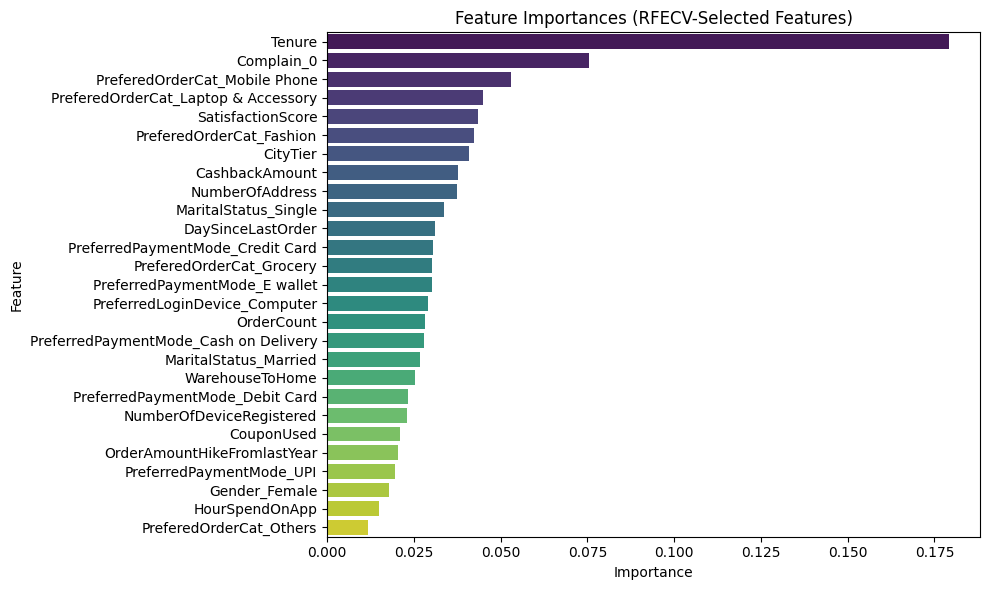

In [69]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load RFECV pipeline ---
rfecv_pipeline = joblib.load("best_selection_model_pipeline.pkl")

# --- Get feature names from preprocessor ---
preprocessor = None
for name, step in rfecv_pipeline.named_steps.items():
    if hasattr(step, "transformers_"):  # ColumnTransformer
        preprocessor = step
        break

if preprocessor is None:
    raise ValueError("Could not find a ColumnTransformer (preprocessor) in the pipeline.")

# Extract feature names after preprocessing
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if hasattr(trans, "get_feature_names_out"):
        feature_names.extend(trans.get_feature_names_out(cols))
    else:
        feature_names.extend(cols)

# --- Get RFECV step ---
rfecv_step = rfecv_pipeline.named_steps["feature_selection"]

# Filter feature names to only selected ones
selected_features = [f for f, keep in zip(feature_names, rfecv_step.support_) if keep]

# --- Get model from pipeline ---
model = rfecv_pipeline.named_steps["model"]

# --- Feature importances ---
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
else:
    raise ValueError("The model does not support feature importances.")

# --- Create DataFrame for selected features ---
feat_imp = pd.DataFrame({
    "Feature": selected_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importances (RFECV-Selected Features)")
plt.tight_layout()
plt.show()

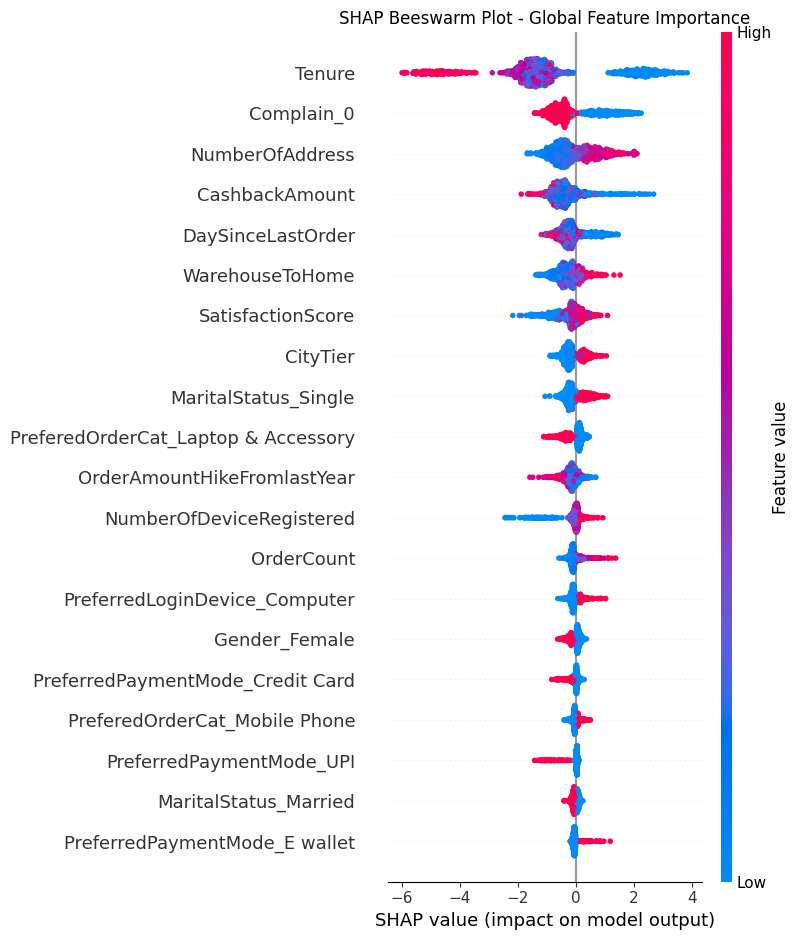

Predicted class: 0
Actual class: 0


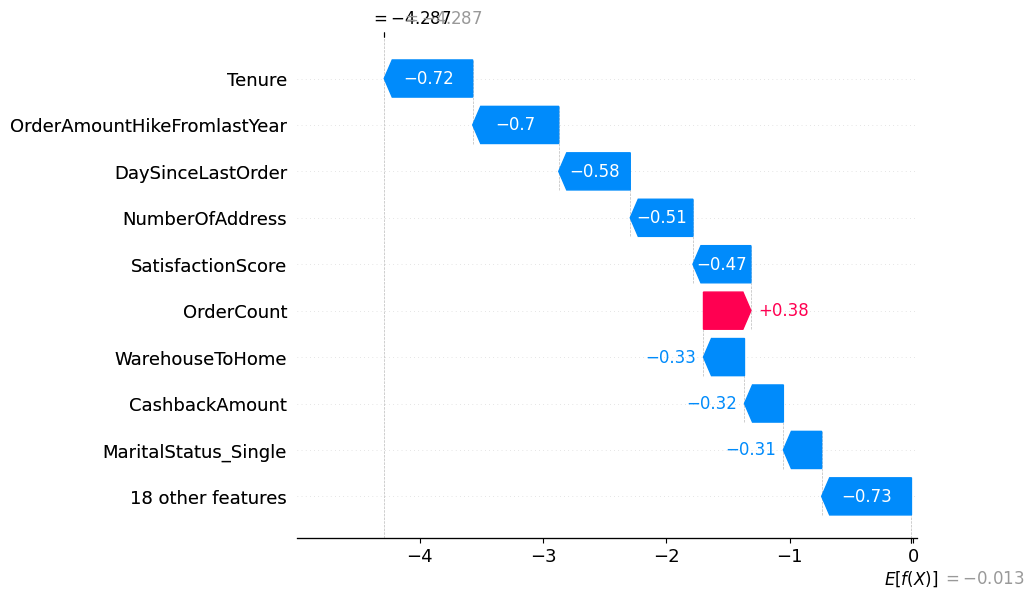

In [75]:
import joblib
import shap
import matplotlib.pyplot as plt

# --- Load the pipeline ---
rfecv_pipeline = joblib.load("best_selection_model_pipeline.pkl")

# Extract pieces
preprocessor = rfecv_pipeline.named_steps["preprocessor"]
rfecv_step = rfecv_pipeline.named_steps["feature_selection"]
model = rfecv_pipeline.named_steps["model"]

# Get feature names
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if hasattr(trans, "get_feature_names_out"):
        feature_names.extend(trans.get_feature_names_out(cols))
    else:
        feature_names.extend(cols)

# Keep only selected features
selected_features = [f for f, keep in zip(feature_names, rfecv_step.support_) if keep]

# Transform test set (everything except final model)
X_test_transformed = rfecv_pipeline[:-1].transform(X_test)

# --- SHAP explainer ---
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed)

# --- 1. Beeswarm plot (global importance) ---
plt.title("SHAP Beeswarm Plot - Global Feature Importance")
shap.summary_plot(shap_values, X_test_transformed, feature_names=selected_features, show=True)

# --- 2. Local explanation for one sample ---
idx = 0  # pick a sample index to inspect
print("Predicted class:", rfecv_pipeline.predict(X_test.iloc[[idx]])[0])
print("Actual class:", y_test.iloc[idx])

# Waterfall plot for that sample
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[idx, :],
    feature_names=selected_features
)
plt.show()

* **Top Predictors of Churn:**
    * **Tenure:** This is the **single most important feature** in predicting churn. Customers with **low tenure** (pink dots on the positive side of the `Tenure` row) have a much higher likelihood of churning, while those with **high tenure** (blue dots on the negative side) are very likely to stay.
    * **Complain:** Customers who have made a complaint (`Complain_0` is false, i.e., they complained) have a very high positive SHAP value, indicating they are **highly likely to churn**.
    * **Number of Addresses:** A **lower number of addresses** (pink dots) is associated with an increased likelihood of churn.
* **Other Key Insights:**
    * **Cashback Amount:** Customers with **low cashback amounts** (pink dots) are more prone to churning.
    * **Day Since Last Order & Warehouse to Home:** Longer periods since the last order and greater distance from the warehouse to home (pink dots) both contribute to a higher churn risk.
    * **Satisfaction Score:** A **higher satisfaction score** (pink dots) is clearly correlated with a higher probability of churning.
    * **Order Count:** While it was a positive factor for the single customer in the waterfall plot, the beeswarm plot shows a more complex relationship. Higher order counts (pink dots on the right) seem to slightly increase churn risk, while lower counts (blue dots) decrease it. This is an interesting finding that may require further investigation, as it could indicate that a high frequency of small orders is a sign of a less engaged customer.

# 6. Conclusion & Recommendations

## 6.1. 📈 Conclusions

A high-performing XGBoost model is successfully developed to predict customer churn. The **Recursive Feature Elimination with Cross-Validation (RFECV)** feature selection process successfully reduced the number of features from 31 to 27 with minimal impact on model performance. The primary metric, **F2-Score**, which prioritizes recall (catching churners), remains excellent for both models, with the feature-selected model achieving a score of **0.965**. This indicates that the model is highly effective at identifying customers at risk of churning.

***

* **Tenure:** This is the **most significant predictor** of churn. New customers (`low Tenure`) are far more likely to churn than long-term customers. This is a common pattern and suggests that the initial customer experience is critical.
* **Customer Complaints:** Having a complaint on file (`Complain_0`) is the **second most important factor** and a very strong indicator of churn risk. Customers who have complained are highly likely to leave.
* **Payment and Login Methods:** The preferred payment mode (`PreferredPaymentMode_Credit Card`, `PreferredPaymentMode_E wallet`) and login device (`PreferredLoginDevice_Computer`) are important signals. This may suggest that customers who use specific methods or devices have different engagement patterns.
* **Marital Status:** Being single (`MaritalStatus_Single`) is a notable predictor of churn, while being married has a smaller impact. This finding aligns with the observation that different customer demographics have different churn probabilities.
* **Order and Engagement Metrics:** Features like `OrderAmountHikeFromlastYear`, `NumberOfAddress`, and `CashbackAmount` all have a strong negative correlation with churn. Customers who show have more addresses, receive higher cashback are much less likely to churn. The `SatisfactionScore` may not have clear measure in what context it is since it has a strong positive correlation with churn. 

## 6.2. Recommendations & Actionable Insights ✅

1.  **Focus on New Customer Retention:** Since `Tenure` is the top predictor, create a proactive retention strategy specifically for new customers in their first few months. This could include personalized onboarding, exclusive offers, or check-in surveys to ensure they have a positive experience.
2.  **Establish a Complaint Resolution Task Force:** Given the strong link between complaints and churn, implement a high-priority system to handle customer complaints swiftly and effectively. The goal should be to resolve issues to the customer's satisfaction within a specific timeframe and monitor their engagement afterward.
3.  **Launch a Customer Engagement Program:** Use the model to identify customers with low `SatisfactionScore` or low `CashbackAmount` and target them with personalized campaigns. For example, offer a loyalty program that rewards higher cashback or a survey with a discount incentive to improve their satisfaction.
4.  **Leverage Feature Selection for Production:** The RFECV-selected model is the best choice for deployment. It uses a smaller number of features (27 vs. 31), which simplifies data collection and processing in a production environment without sacrificing performance. The high F2-score and ROC-AUC for this model prove its reliability.
5.  **Develop Targeted Campaigns for Specific Demographics:** Use the insights from the `MaritalStatus` feature to create tailored marketing campaigns. For example, offer benefits or products that appeal to single customers to increase their engagement and loyalty.

## ⚡ 6.3. Measurable Business Impact

![](./assets/final_confusion_matrix.png)

### Assumptions for this Simulation 💰

To quantify the impact, we'll assign monetary values based on common business metrics.

* **Average Customer Lifetime Value (CLV):** Let's assume the average customer generates **$480** in revenue over their lifetime.
* **Customer Retention Cost (CRC):** The cost to save an at-risk customer (e.g., a discount, a personalized call) is **$50**.
* **Customer Acquisition Cost (CAC):** Based on the principle that CAC is 5x CRC, we'll set this at **$250**.

Using the Confusion Matrix for the **Feature Selection (RFECV)** model, here's how we measure the impact for a sample of 1,126 customers.

***

### 1. The Cost of Mistakes

#### **False Negatives (FN): The Most Expensive Error**
These are customers the model missed, and who subsequently churned. This is the core reason for building a churn model.
* **Number of FNs:** 4 customers
* **Business Impact:** You lose their lifetime value and must spend money to acquire a new customer to replace them.
* **Cost Calculation:** 4 FNs × (Lost CLV + CAC)
* **Total Cost:** 4 × ($480 + $250) = **$2,920**

#### **False Positives (FP): The Less Costly Error**
These are customers the model incorrectly flagged as at-risk, so you spent resources on them unnecessarily.
* **Number of FPs:** 18 customers
* **Business Impact:** This is a wasted retention cost. You spend money on a customer who would have stayed anyway.
* **Cost Calculation:** 18 FPs × CRC
* **Total Cost:** 18 × $50 = **$900**

***

### 2. The Value of Correct Predictions

#### **True Positives (TP): The Highest ROI**
These are customers the model correctly identified as at-risk. You can now act to save them.
* **Number of TPs:** 186 customers
* **Business Impact:** You successfully saved a customer's lifetime value by spending a small retention cost.
* **Value Calculation:** 186 TPs × (CLV saved - CRC spent)
* **Total Value:** 186 × ($480 - $50) = **$79,980**

#### **True Negatives (TN): The Baseline**
These are customers correctly identified as loyal, so no action is needed.
* **Number of TNs:** 918 customers
* **Business Impact:** The model helps you save money by confirming who is safe, so you don't waste resources.
* **Total Value:** 918 TNs × ($0 cost) = **$0** (in immediate cost savings, the value is in avoiding unnecessary spending).

***

### Summary of Measurable Impact

By deploying this model, the business gains a clear financial advantage:

| Prediction Outcome    | Financial Value (or Cost) |
|-----------------------|---------------------------|
| **Total Value from TP** | **+$79,980** |
| **Total Cost from FP** | **-$900** |
| **Total Cost from FN** | **-$2,920** |
| **Net Financial Impact**| **+$76,160** |

The analysis shows that the **net value created by the model is over $76,000** for this group of customers. The model is exceptionally good at preventing the most expensive mistake (churning customers) and generates a huge return on the small costs of its misclassifications.